In [212]:
import os
import time
import datetime
import calendar
import glob
import csv
import matplotlib.pyplot as plt
import numpy as np
import re

X = "x"
Y = "y"

test_duration = [200, 110, 130, 120]

scenario_list = [(i, f"s{i}", test_duration[i - 1]) for i in range(1, 5)]
print(scenario_list)

number_of_peers_list = [(i, f"n{i:02}") for i in [2, 4, 8]]
print(number_of_peers_list)

CRDT_CLIENT_SERVER = 0
CRDT_P2P = 1
OT_CLIENT_SERVER = 2
type_list = [(0, "crdt-cs", "red"), (1, "crdt-p2p", "green"), (2, "ot", "blue")]
print(type_list)

parameter_list = ["cpu", "mem", "network-in", "network-out"]
parameter_label = {
    "cpu" : "Catatan: dalam satuan %, utilisasi CPU aplikasi, 100% = 1 core",
    "network-in" : "Catatan: dalam satuan Kilobits/s, kecepatan bandwidth data yang masuk atau diterima",
    "network-out" : "Catatan: dalam satuan Kilobits/s, kecepatan bandwidth data yang keluar atau dikirim",
    "mem": "Catatan: dalam satuan Mebibytes, penggunaan memori aplikasi yang sudah normalized (dimulai dari 0 saat inisialisasi test)"
}

from termcolor import colored
def declare_scenario(current_scenario):
    print(colored(f"Currently computing Scenario {current_scenario}", "red"))

def declare_n(current_n):
    print(colored(f"Currently computing for peers {current_n}", "blue"))

def parse_log_time(time_str):
    # 2022-11-02 18:04:00.001
    element = datetime.datetime.strptime(time_str,"%Y-%m-%d %H:%M:%S.%f").timetuple()
    return element

[(1, 's1', 200), (2, 's2', 110), (3, 's3', 130), (4, 's4', 120)]
[(2, 'n02'), (4, 'n04'), (8, 'n08')]
[(0, 'crdt-cs', 'red'), (1, 'crdt-p2p', 'green'), (2, 'ot', 'blue')]


In [247]:
def scenario(idx, normalize_mem = 9):
    logger = [["parameter","peer number","instance", "avg", "med", "max", "min"]]
    current_scenario = scenario_list[idx]
    declare_scenario(current_scenario)
    disconnection_exist = scenario_list[idx][0] <= 2
    for n in number_of_peers_list:
        declare_n(n)
        data_path = os.path.join(os.getcwd(), current_scenario[1], n[1])

        plotting_groups = dict()
        for server_kind in type_list:

            start_time = None
            end_time = None
            for i in range(1, n[0] + 1):
                log_path = os.path.join(data_path, server_kind[1], f"peer-{i}")
                # print(log_path)
                log_file = glob.glob(f"{log_path}/*.log")
                assert(len(log_file) == 1)
                assert(os.path.isdir(log_path))
                log_file = log_file[0]
                
                with open(log_file, 'r') as log_buffer:
                    log_data = log_buffer.read()
                    test_start_line = re.search("\[(.+?)\].+Test Start", log_data)
                    timestamp_str = test_start_line.groups()[0]
                    timestamp_str = parse_log_time(timestamp_str)
                    # print(timestamp_str)
                    timestamp_int = int(calendar.timegm(timestamp_str))
                    if(start_time == None):
                        start_time = timestamp_int
                    assert(start_time == timestamp_int)

                    try:
                        test_start_line = re.search("\[(.+?)\].+Exit Test", log_data)
                        timestamp_str = test_start_line.groups()[0]
                        timestamp_str = parse_log_time(timestamp_str)
                        # print(timestamp_str)
                        timestamp_int = int(calendar.timegm(timestamp_str))

                        if(end_time == None):
                            end_time = timestamp_int
                        # print(log_path)
                        # print(end_time, timestamp_int)
                        end_time = max(end_time, timestamp_int)
                        assert(abs(end_time-timestamp_int) <= 10)
                    except:
                        print(colored(f"{log_path} Doesn't end!", "red"))
                        pass

            # start_time already got from log, now time to plot
            # wpen csv file
            for parameter in parameter_list:
                # print(parameter)
                parameter_log_path = os.path.join(data_path, server_kind[1])
                parameter_log_glob = glob.glob(f"{parameter_log_path}/{parameter.split('-')[0]}-*.csv")
                for parameter_glob_path in parameter_log_glob:
                    # print(parameter_glob_path)
                    parameter_glob_path_name = parameter_glob_path.split('/')[-1]
                    # print(parameter_glob_path_name)
                    instance_category = re.search(f"{parameter.split('-')[0]}-(.+?)\.csv", parameter_glob_path_name)
                    instance_category = instance_category.groups()[0]
                    is_peer = ""
                    group_parameter = parameter
                    if("peer" in instance_category):
                        group_parameter += f"-peers"
                        instance_category += f"-{server_kind[1]}"
                    # print(instance_category)
                    plotting_groups.setdefault(group_parameter, dict())
                    current_group = plotting_groups[group_parameter]
                    current_group.setdefault(instance_category, dict())
                    current_entry = current_group[instance_category]
                    x_min = start_time - 10
                    x_max = end_time + 10
                    x = []
                    y = []
                    with open(parameter_glob_path, 'r') as parameter_log_buffer:
                        reader = list(csv.reader(parameter_log_buffer))
                        reader_len = len(reader)
                        for i in range(1, reader_len):
                            # print(reader[i])
                            if(x_min <= int(reader[i][0]) <= x_max):
                                x.append(int(reader[i][0]) - x_min)
                                if(parameter == "network-out"):
                                    y.append(float(reader[i][2]))
                                else:
                                    y.append(float(reader[i][1]))
                    y = [j for _, j in sorted(zip(x, y))]
                    x.sort()
                    current_entry["x"] = x
                    current_entry["y"] = y
        for parameter in plotting_groups.keys():
            current_group = plotting_groups[parameter]
            fig = plt.figure(figsize=(12, 7))
            plt.title(f"{parameter}\n{parameter_label[parameter.strip('-peers')]}")
                # Normalize to 0
            for instance in current_group.keys():
                current_instance = current_group[instance]
                if(parameter.startswith("mem")):
                    # print(parameter)
                    first_el = current_instance[Y][normalize_mem]
                    for i in range(len(current_instance[Y])):
                        current_instance[Y][i] -= first_el
                total = 0
                # print(current_scenario)
                START_FROM = 10
                running = []
                for i in range(len(current_instance[Y])):
                    if(START_FROM <= current_instance[X][i] <= START_FROM + current_scenario[2]):
                        running.append(current_instance[Y][i])
                tmp_label = f"{instance} avg={np.average(running):.3f}"
                plt.plot(current_instance[X], current_instance[Y], label=tmp_label)
                tmp_log = [parameter,n[0],instance,np.average(running),np.median(running),np.max(running),np.min(running)]
                logger.append(tmp_log)
            plt.xticks(np.arange(10, 300, 30), [i for i in np.arange(0, 300, 30)])
            plt.xlabel(f'''Detik berjalan (s)

Skenario {current_scenario[0]}, $n$ = {n[0]}''')
            plt.legend()
            plt.grid()
            plt.show()
    with open(f"log-scenario-{current_scenario[0]}.csv", "w") as log_buffer:
        writer = csv.writer(log_buffer)
        writer.writerows(logger)

Currently computing Scenario (1, 's1', 200)
Currently computing for peers (2, 'n02')


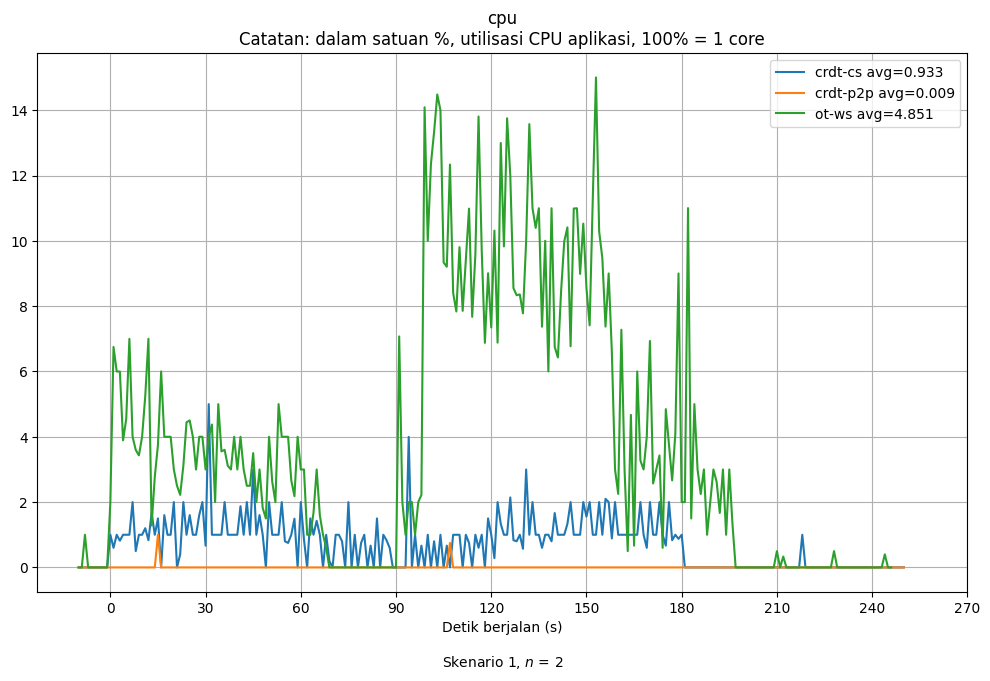

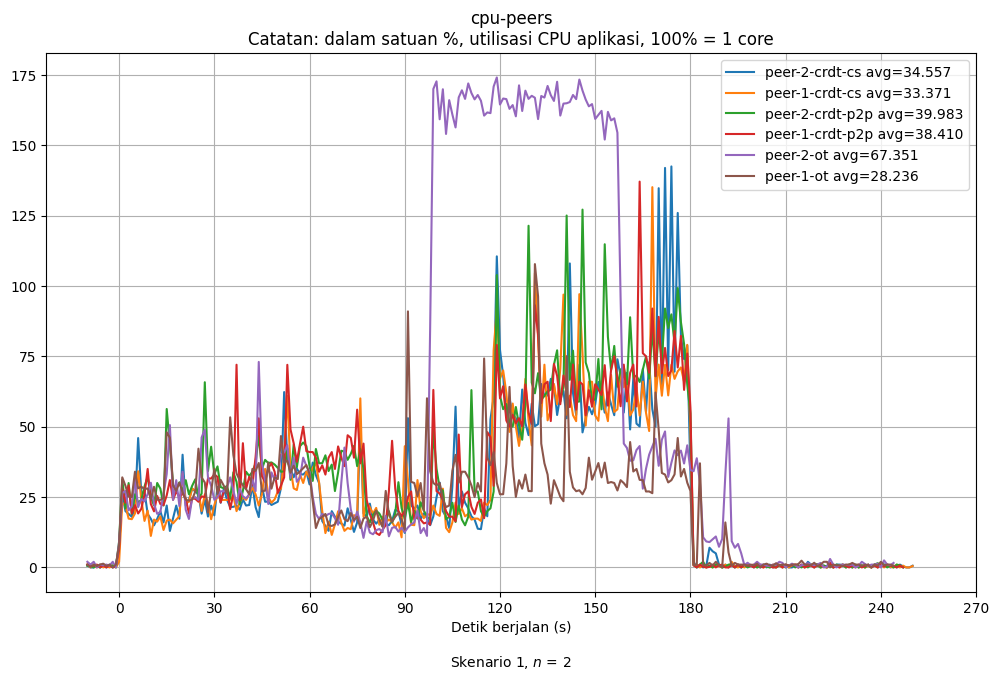

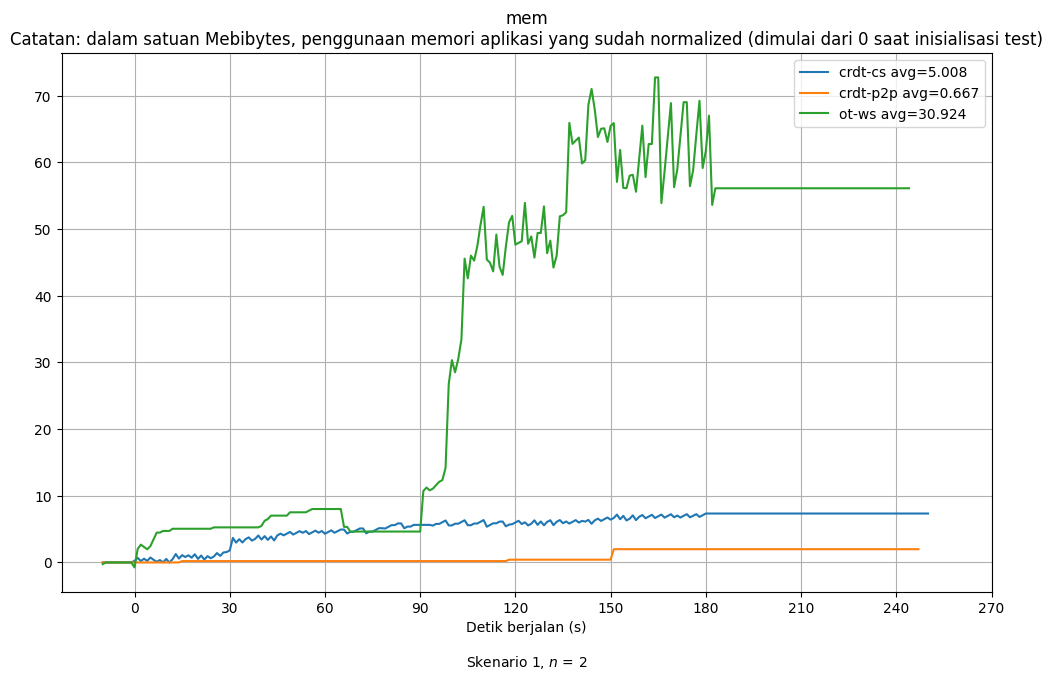

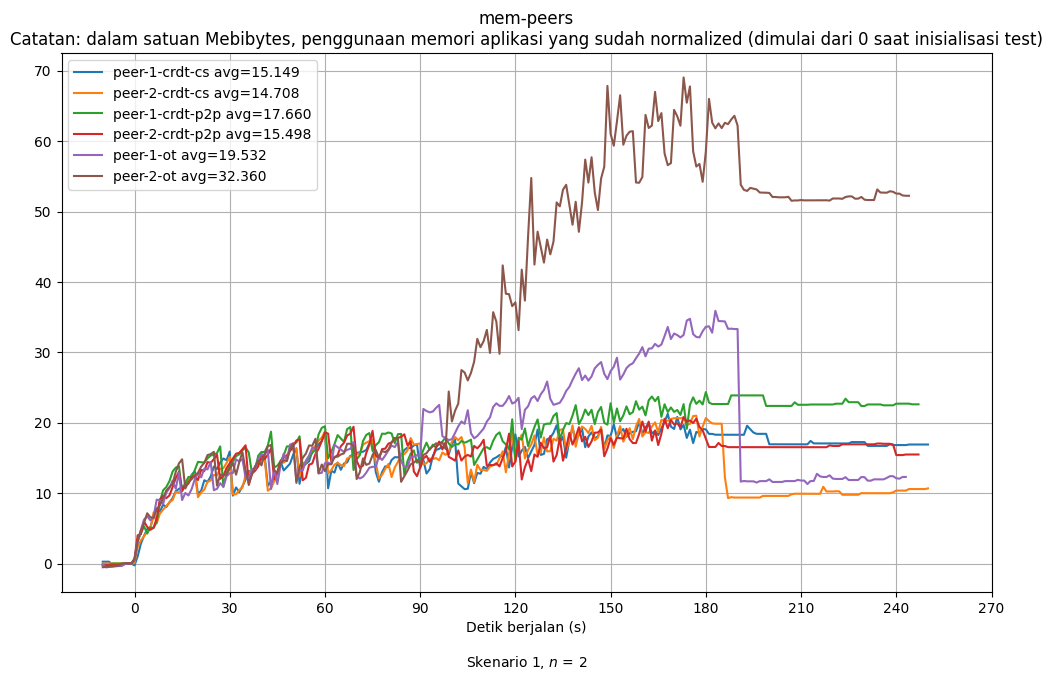

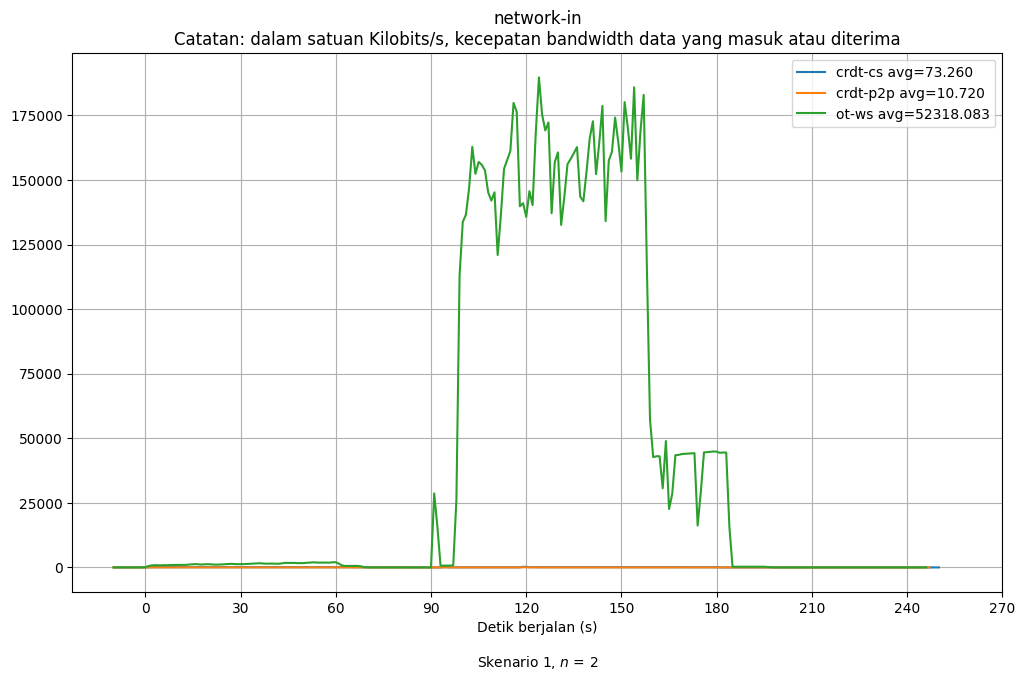

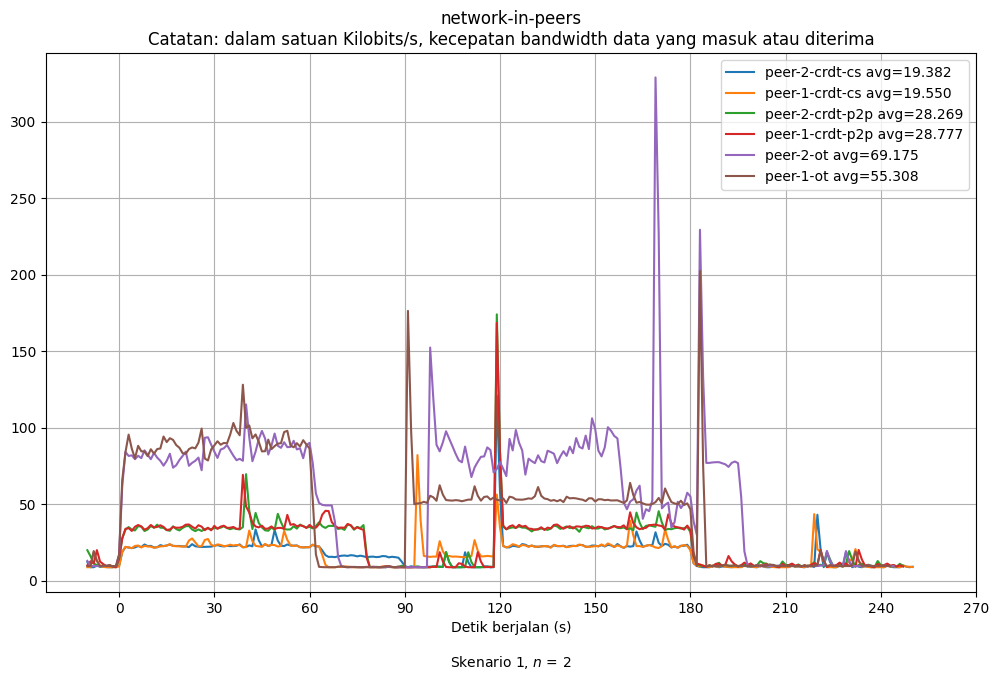

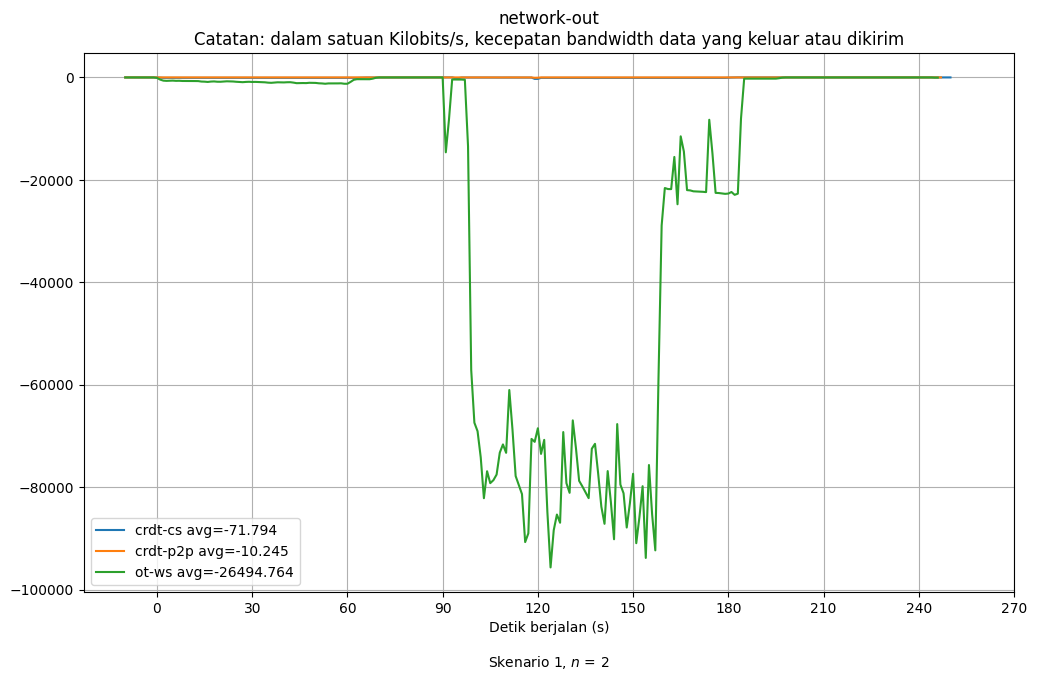

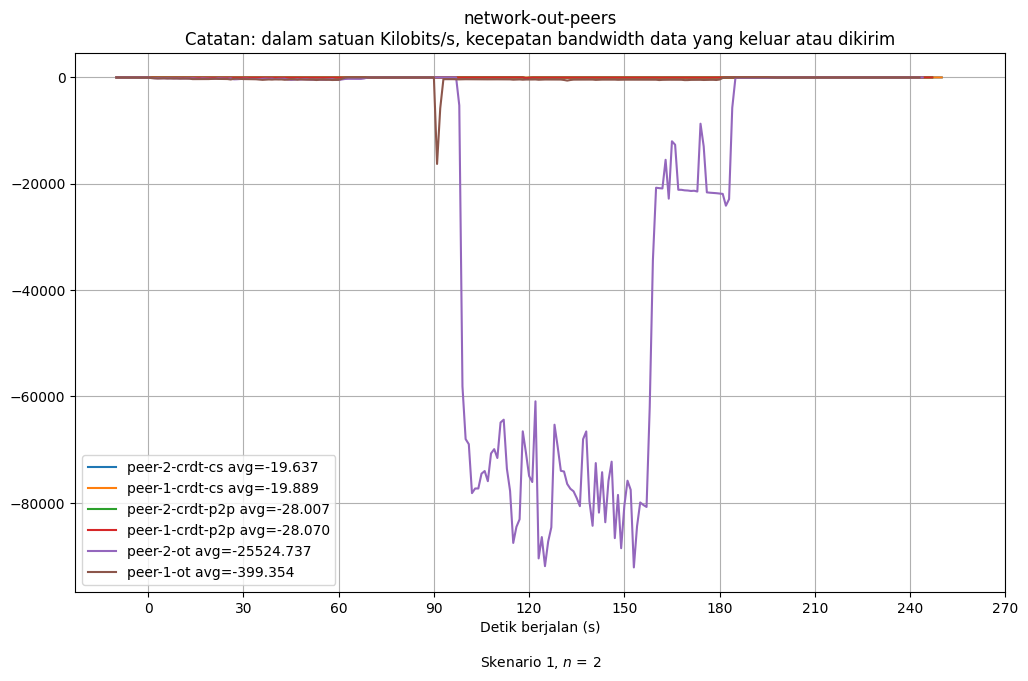

Currently computing for peers (4, 'n04')


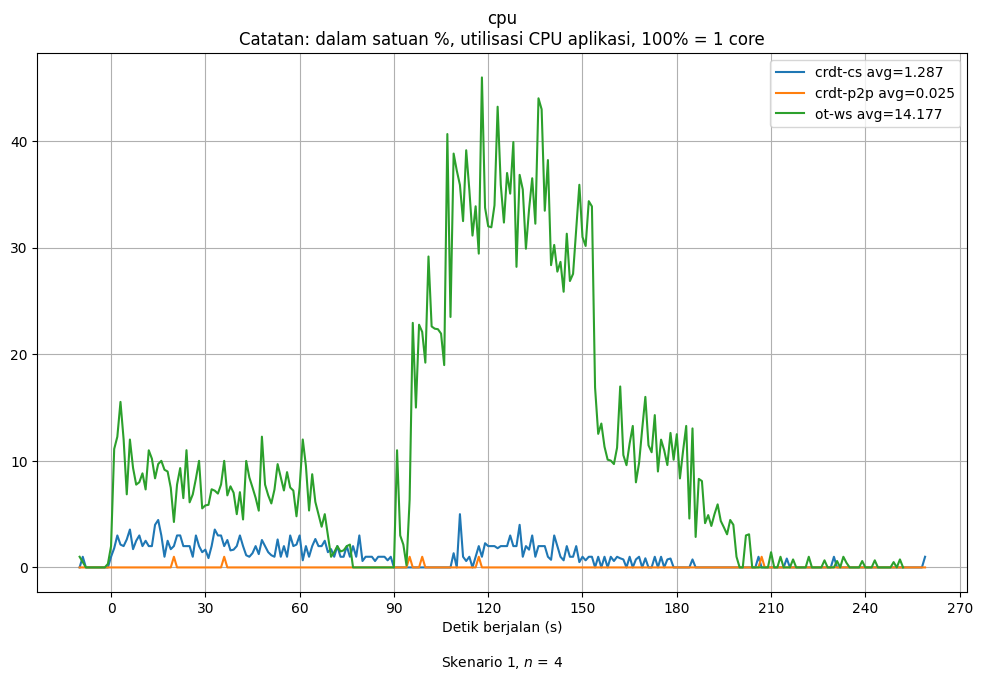

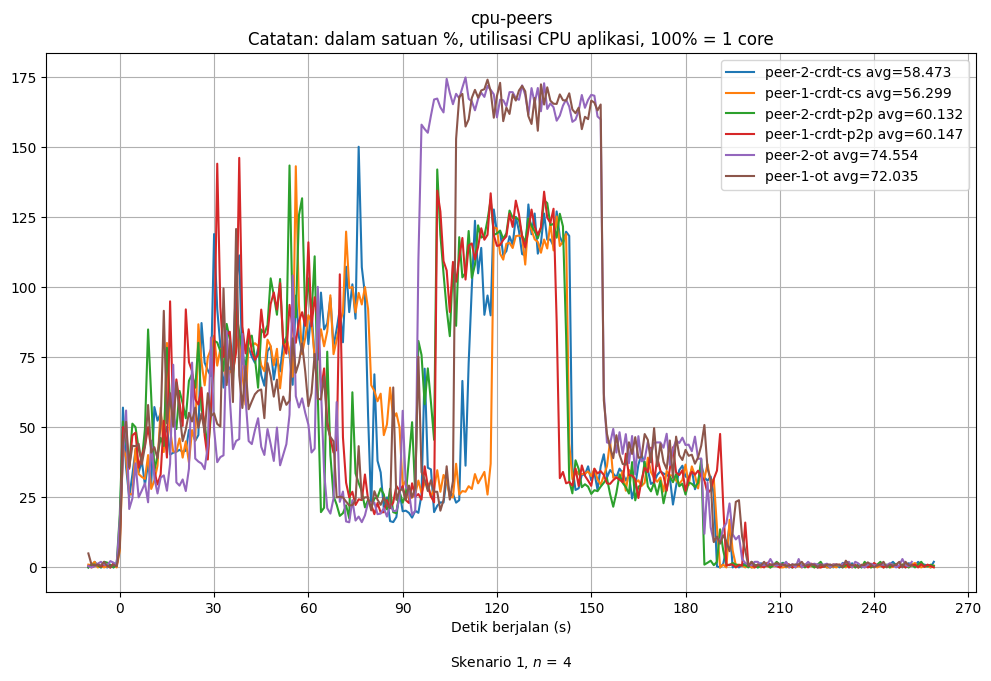

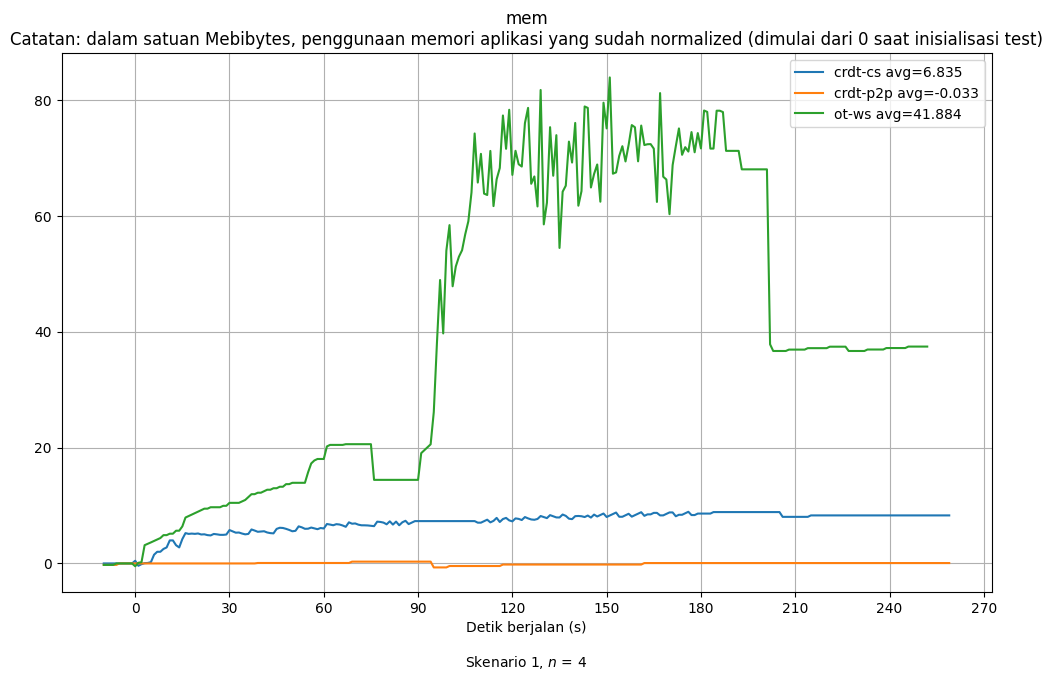

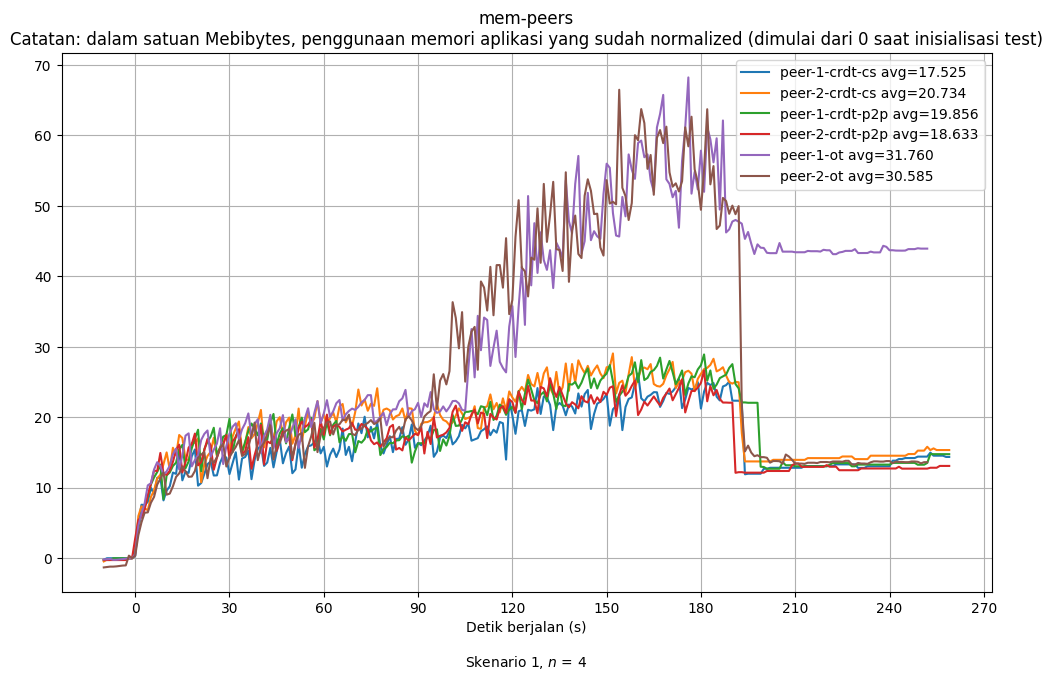

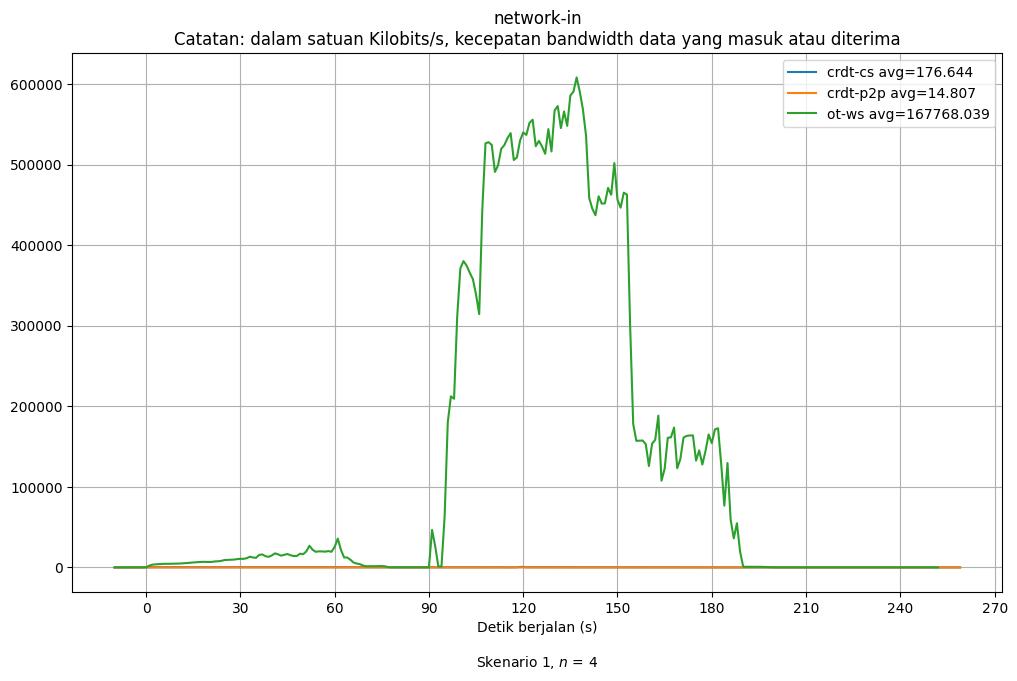

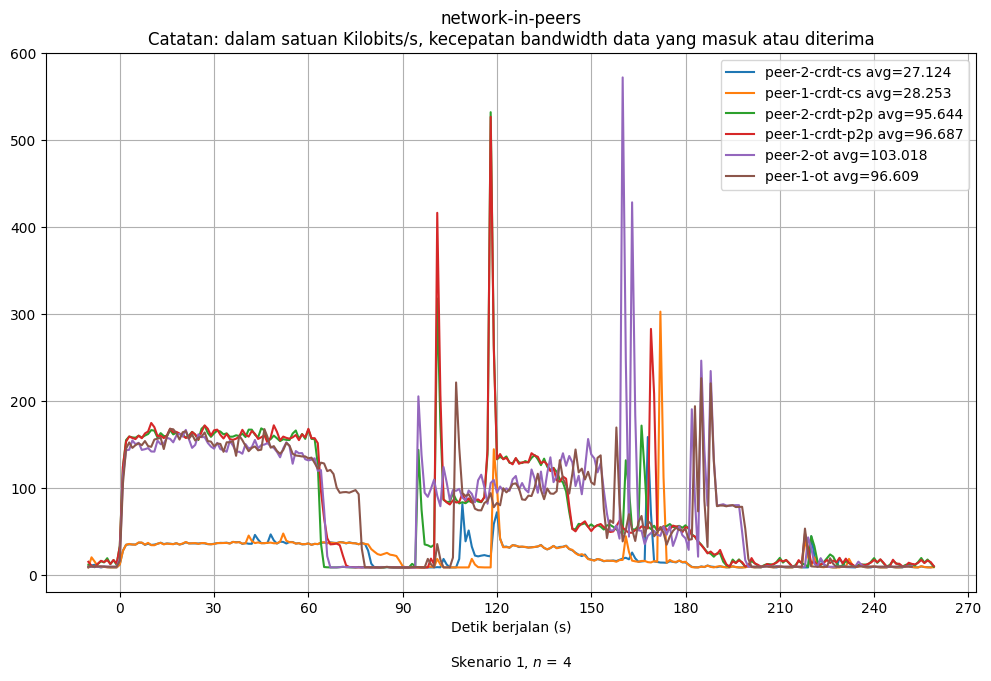

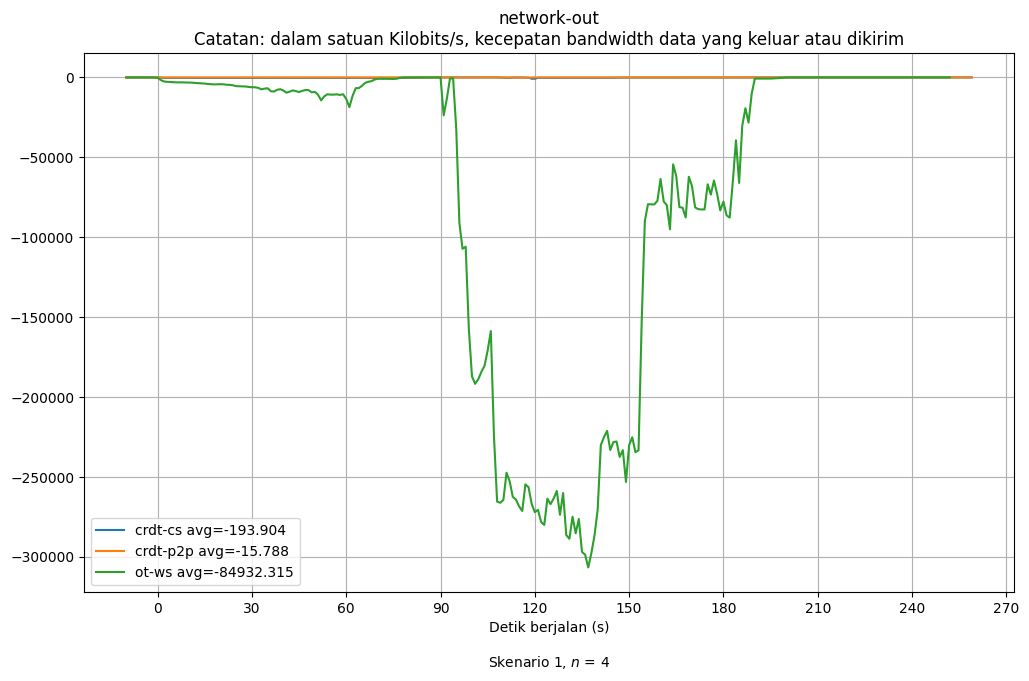

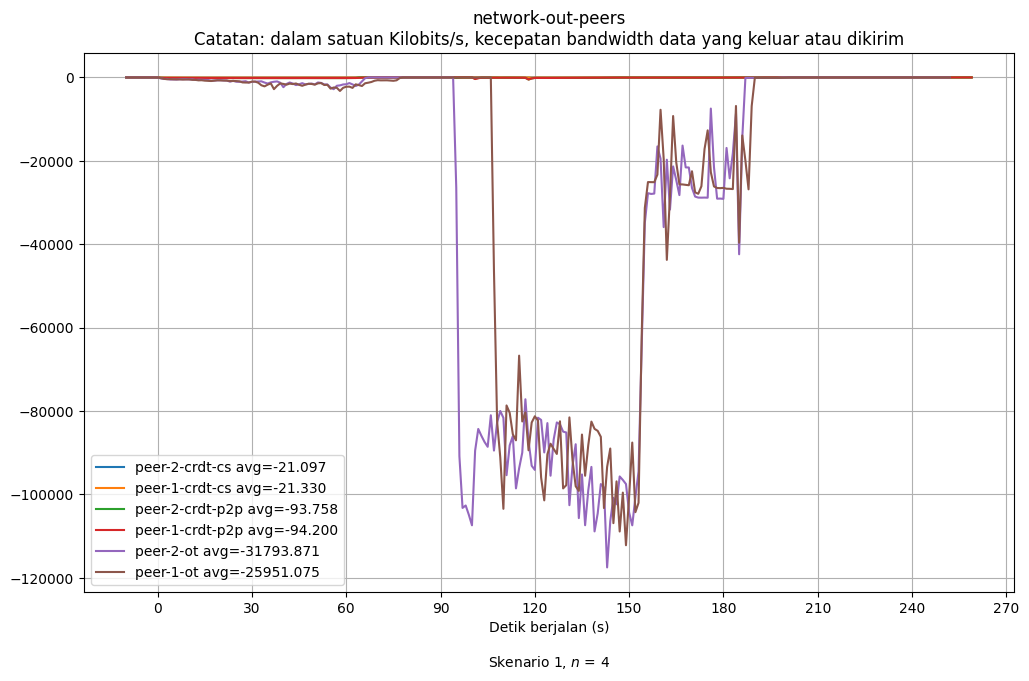

In [248]:
scenario(0)

Currently computing Scenario (2, 's2')
Currently computing for peers (2, 'n02')


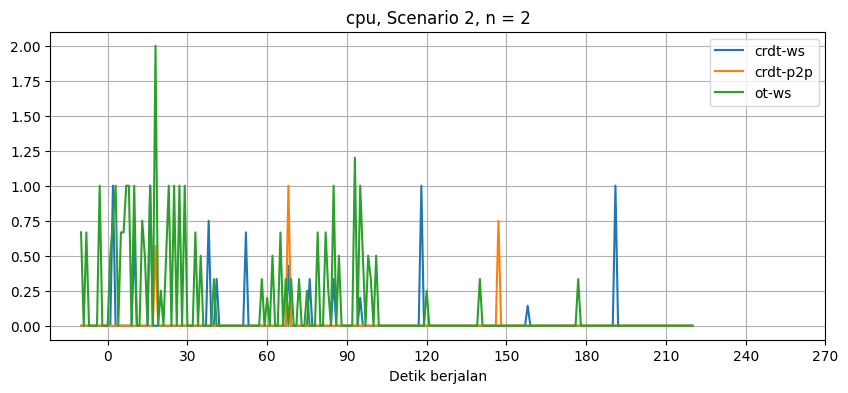

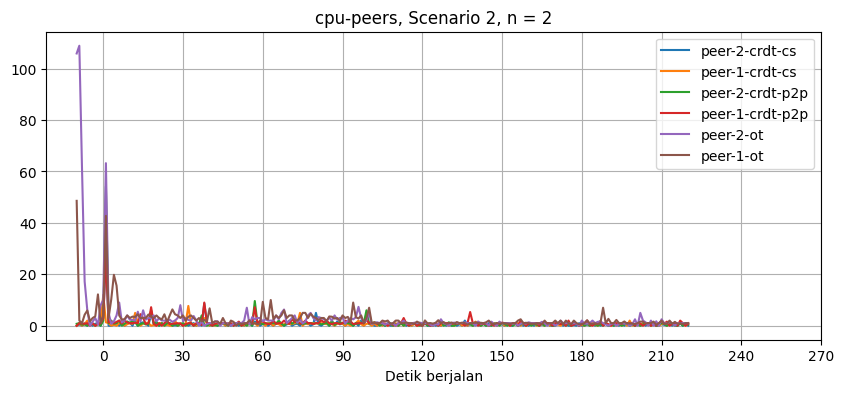

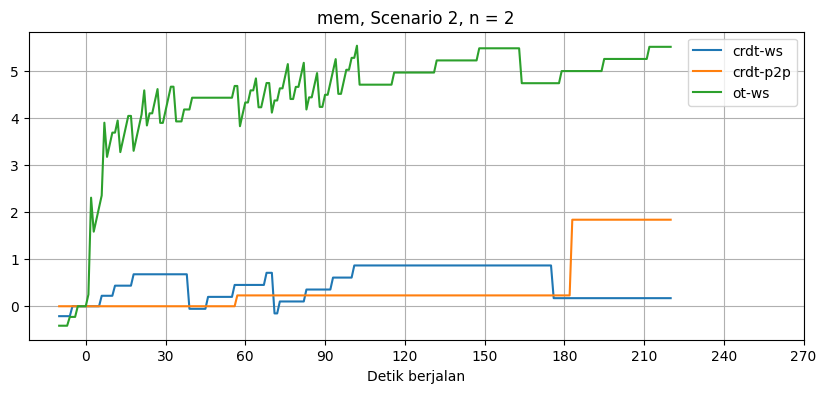

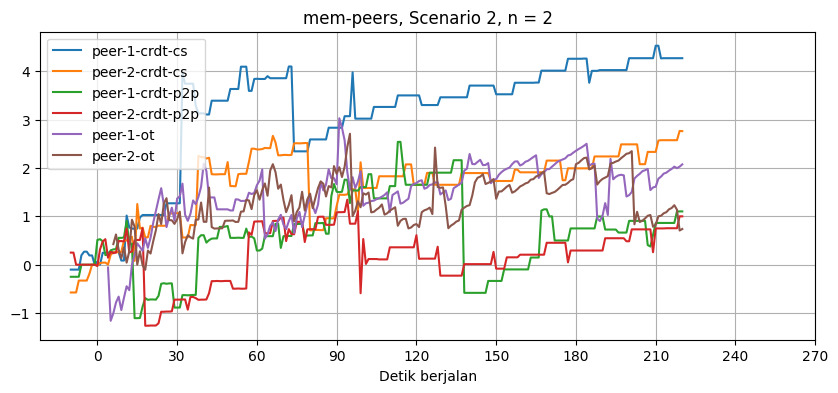

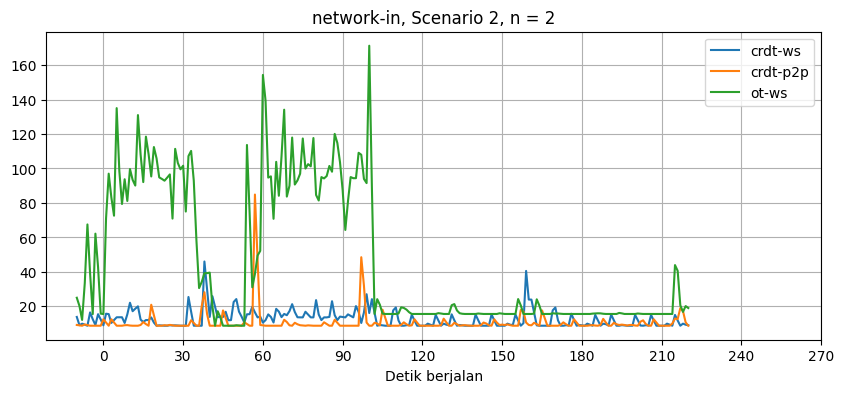

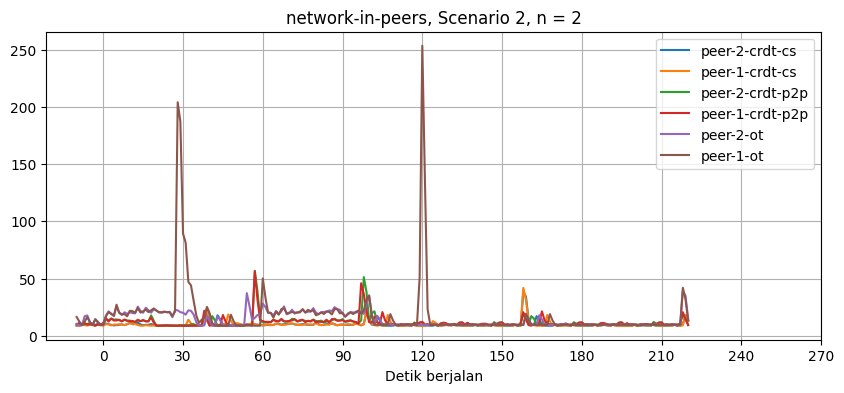

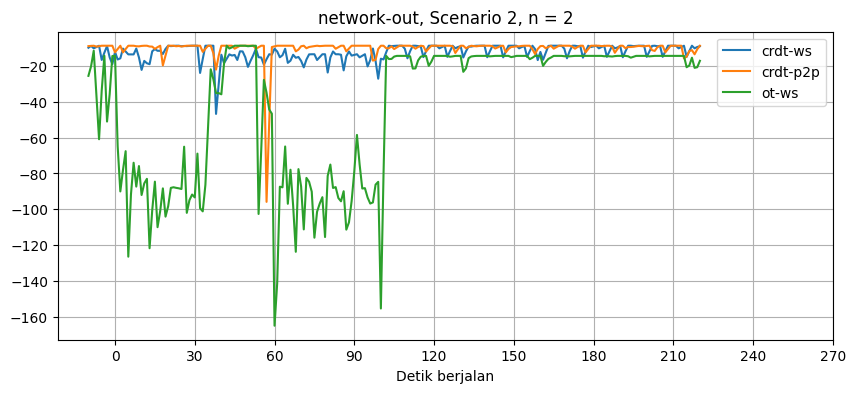

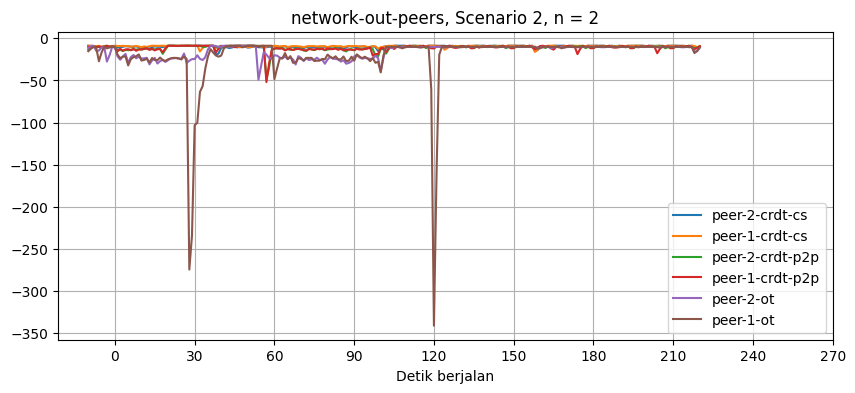

Currently computing for peers (4, 'n04')


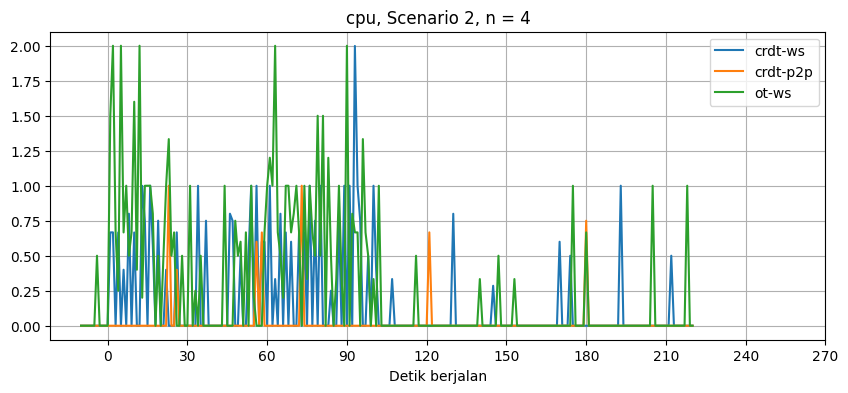

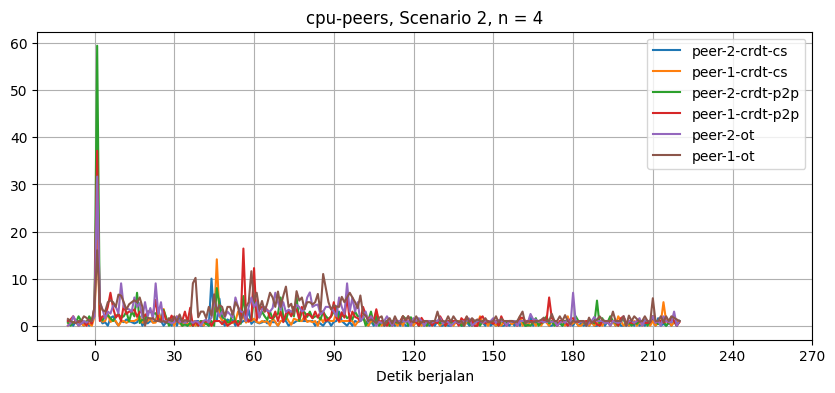

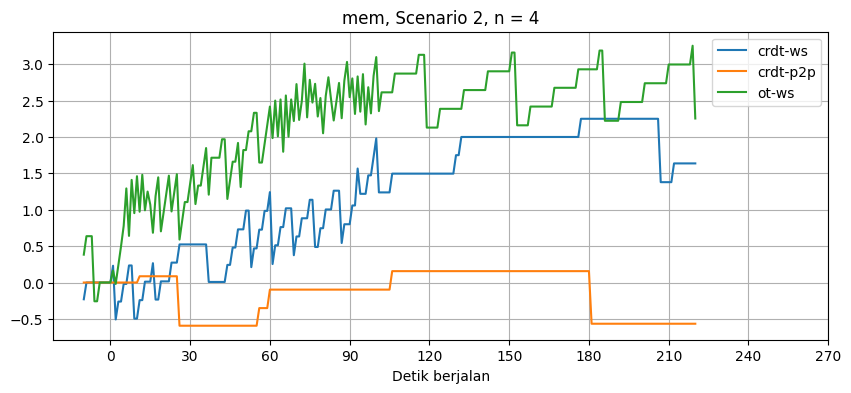

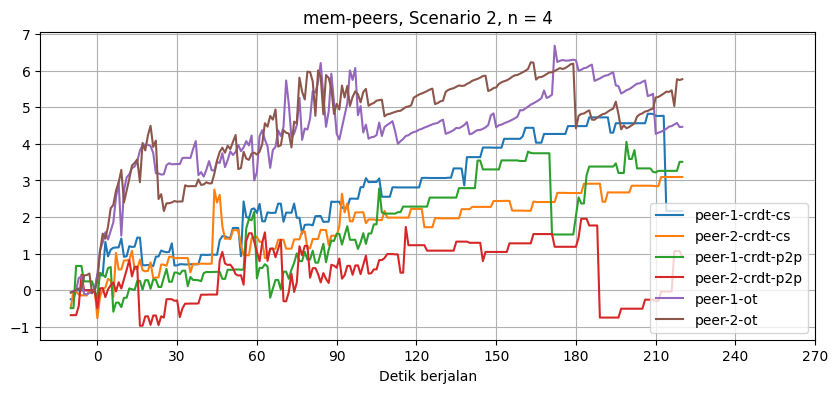

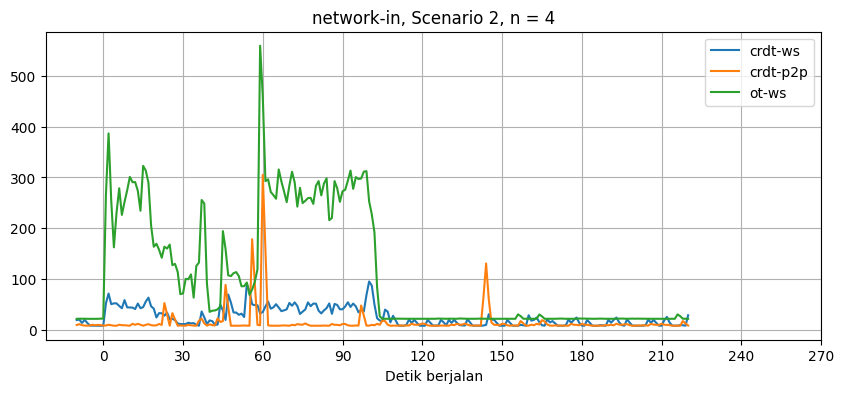

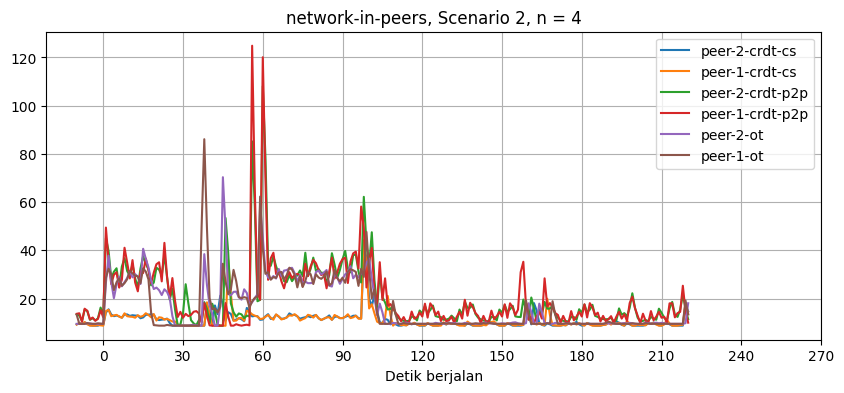

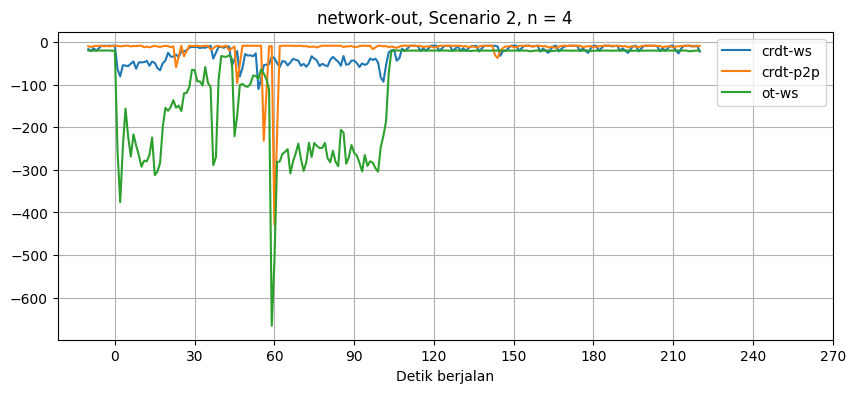

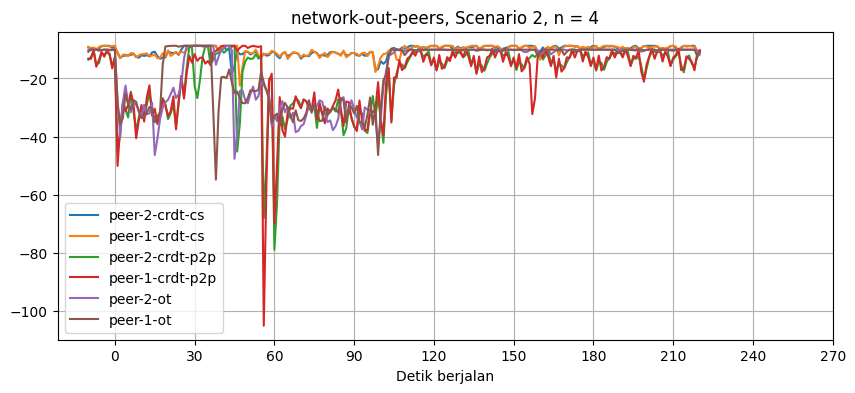

Currently computing for peers (8, 'n08')


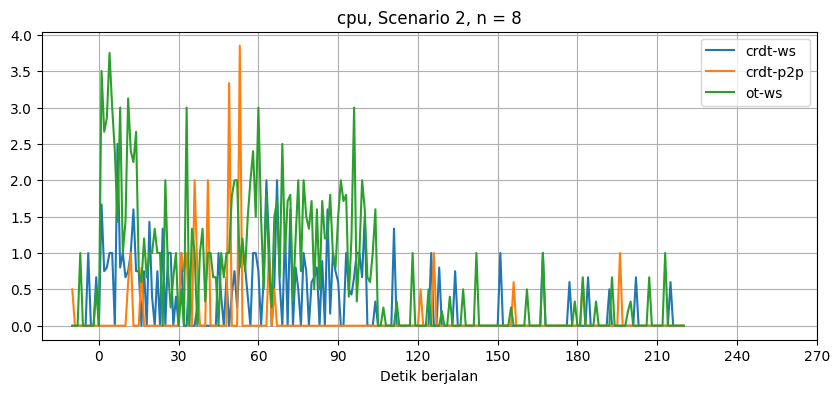

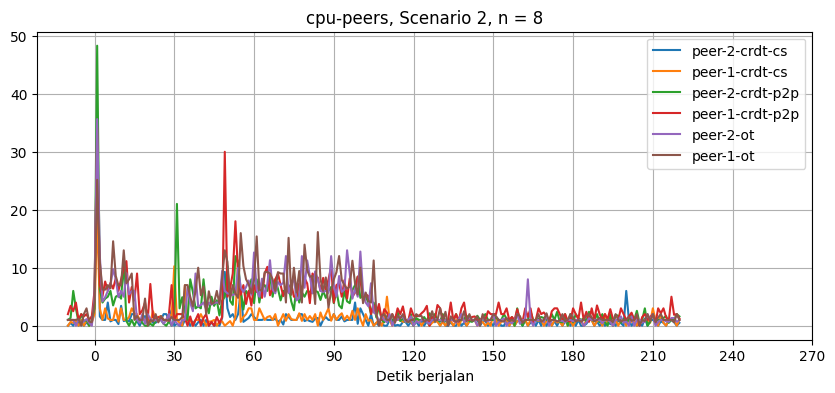

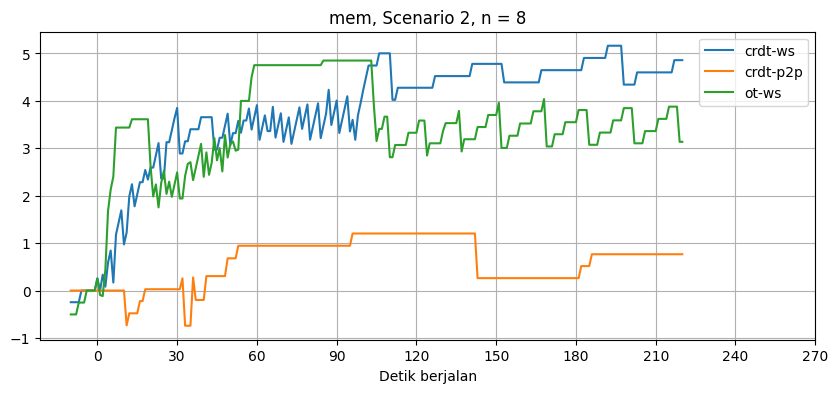

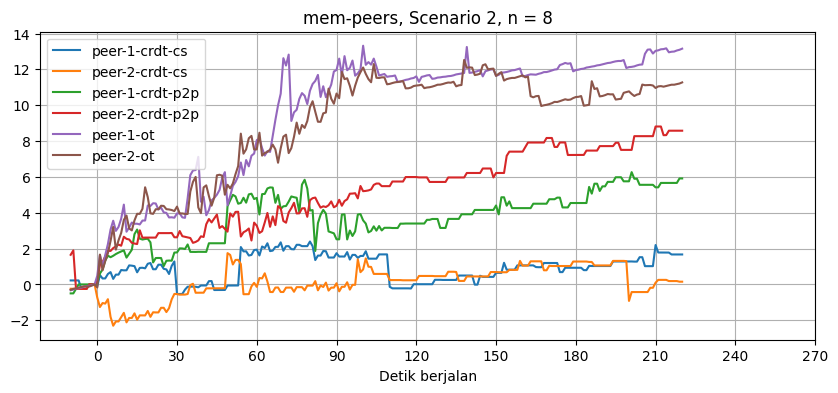

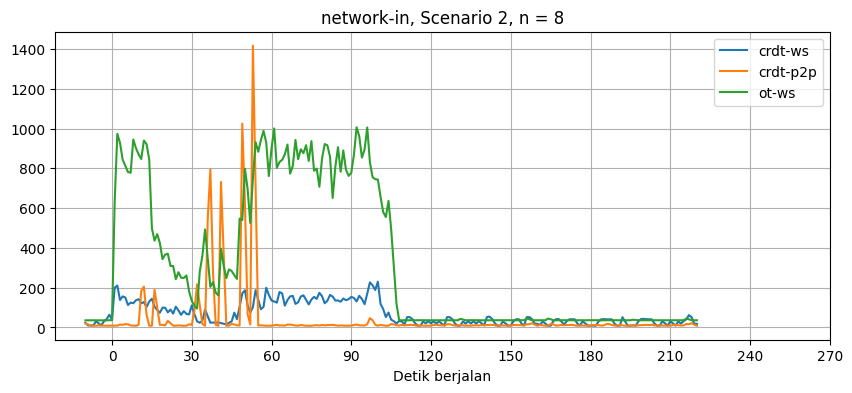

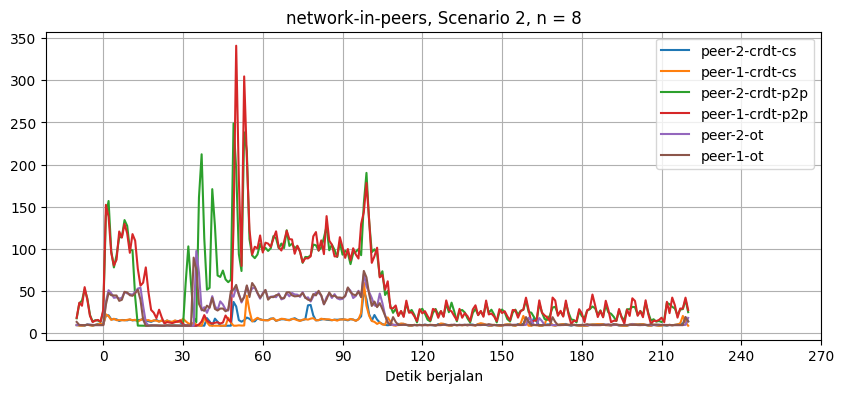

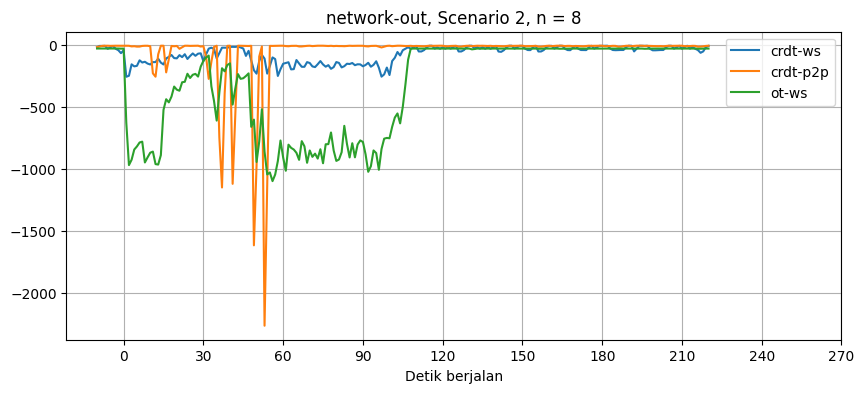

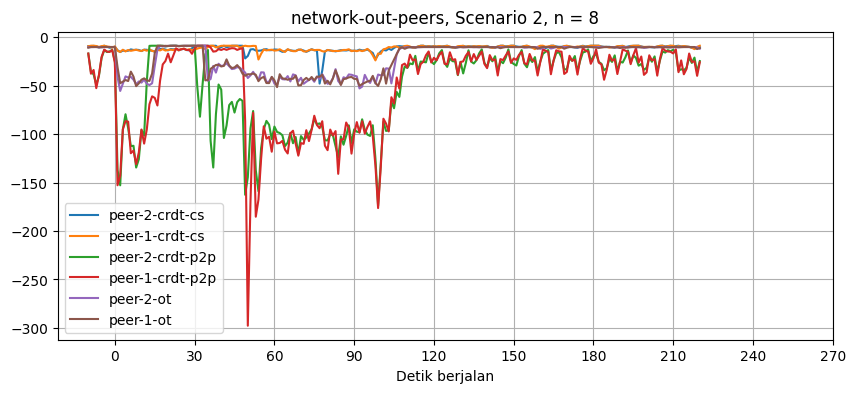

In [176]:
scenario(1)

Currently computing Scenario (3, 's3')
Currently computing for peers (2, 'n02')


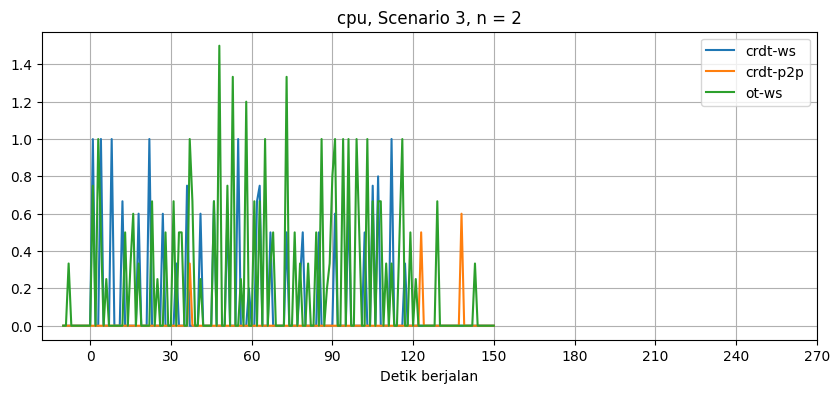

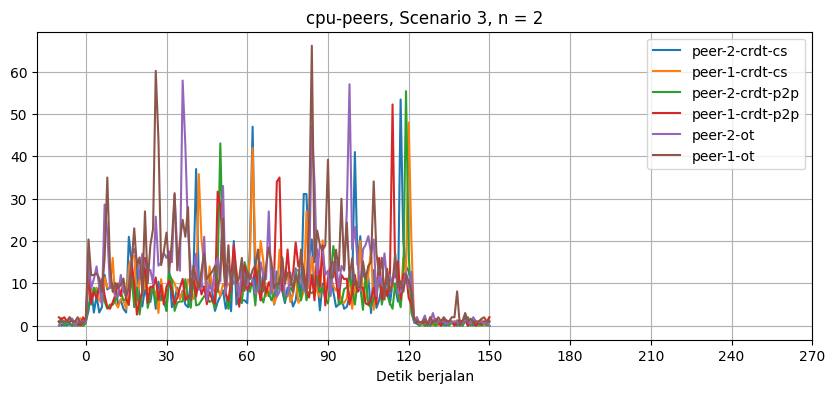

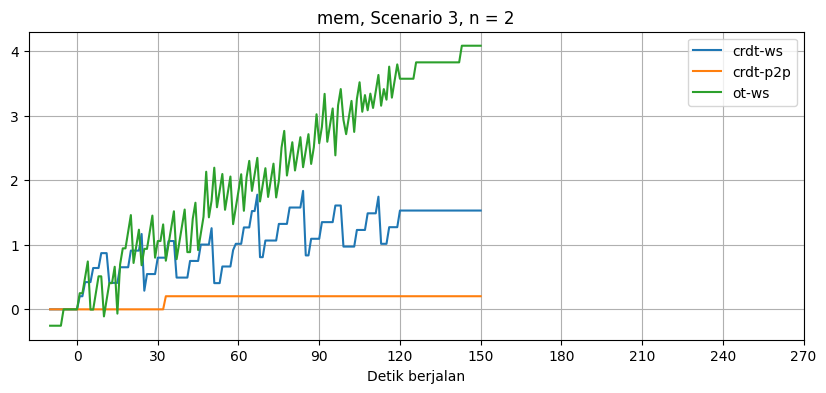

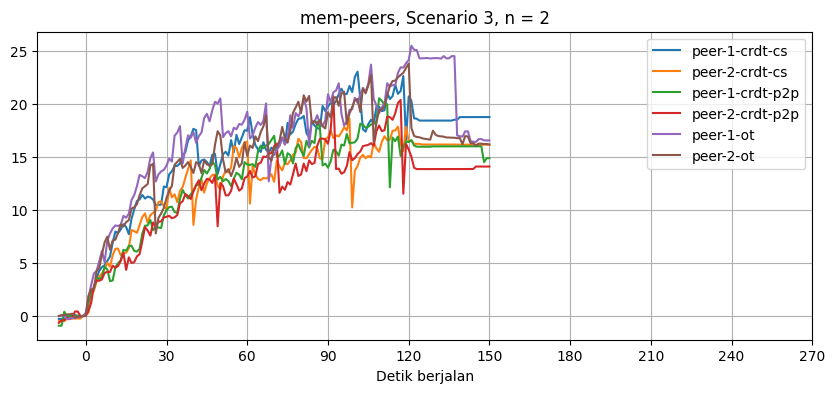

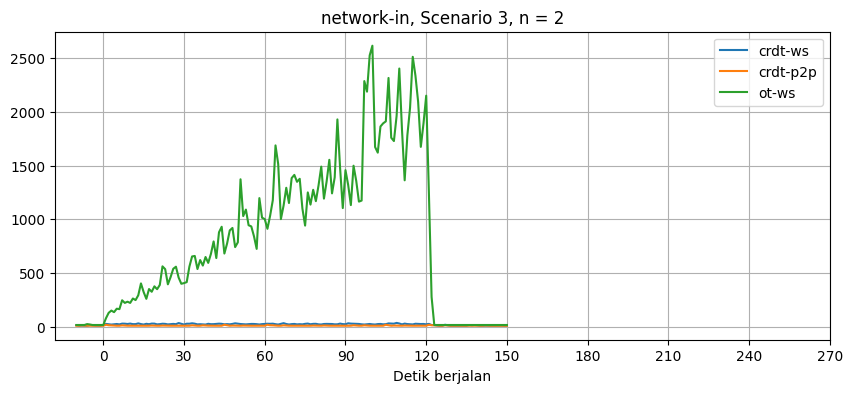

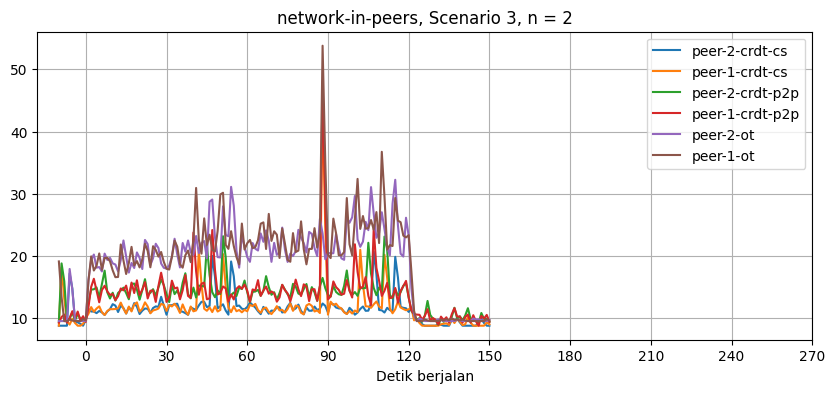

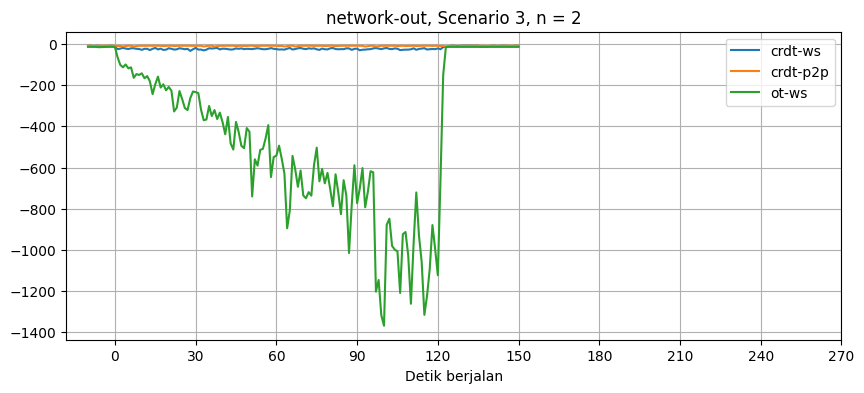

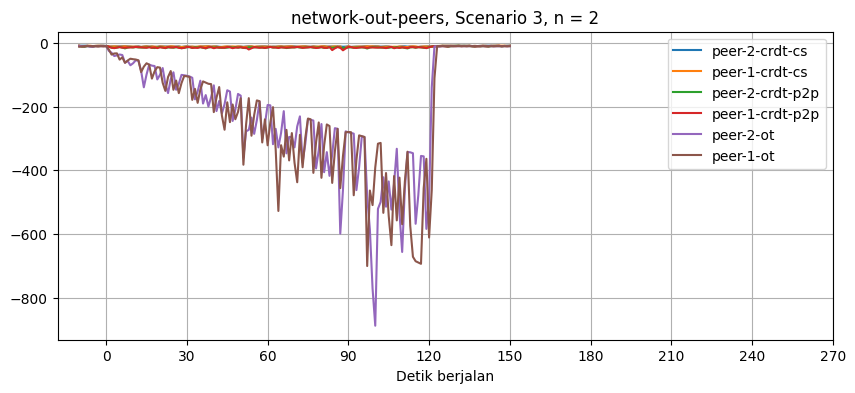

Currently computing for peers (4, 'n04')


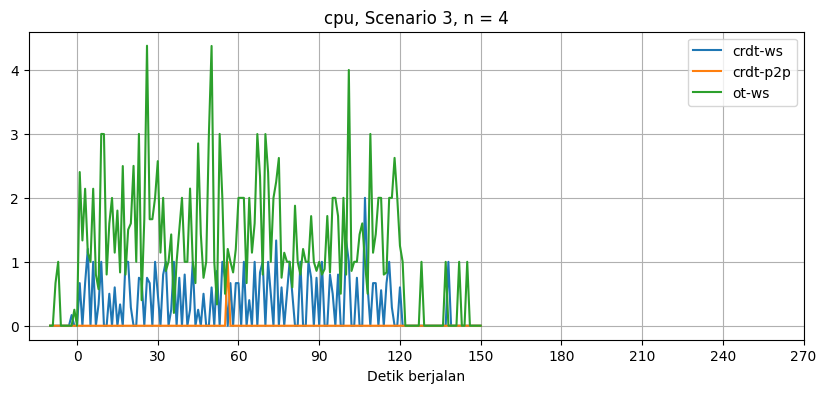

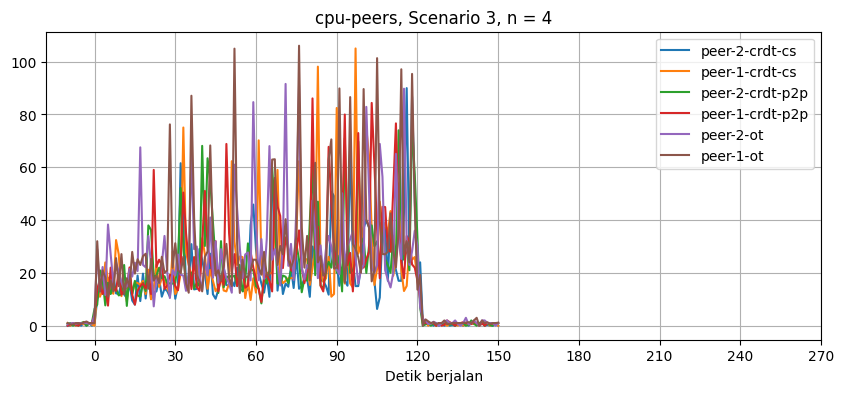

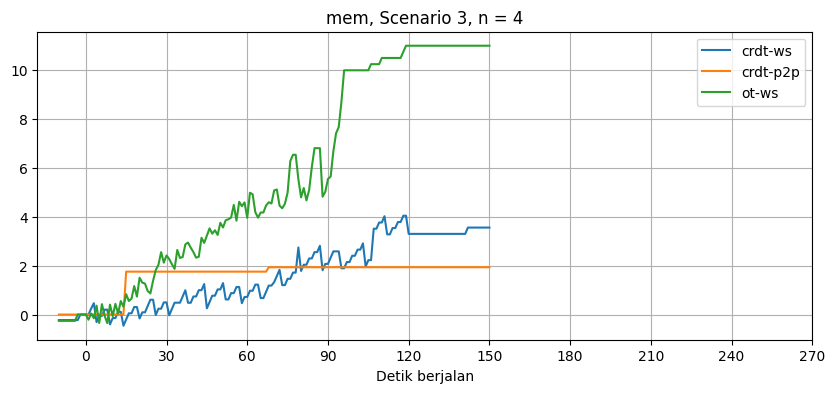

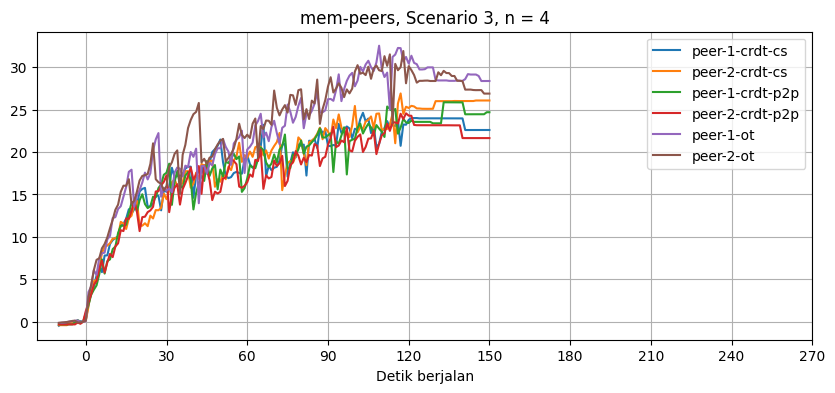

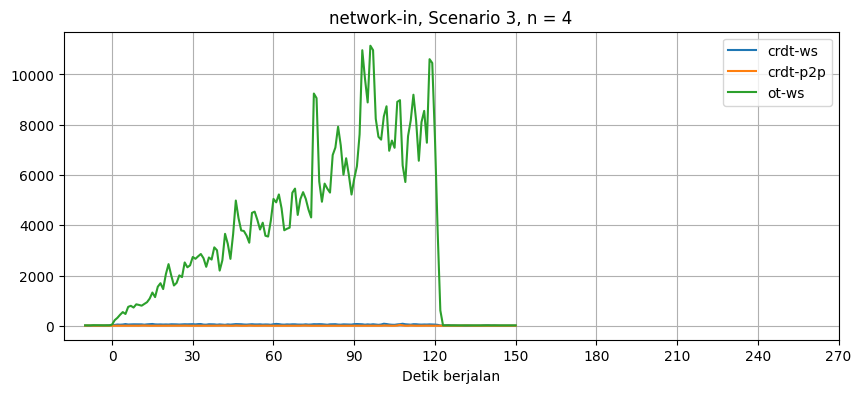

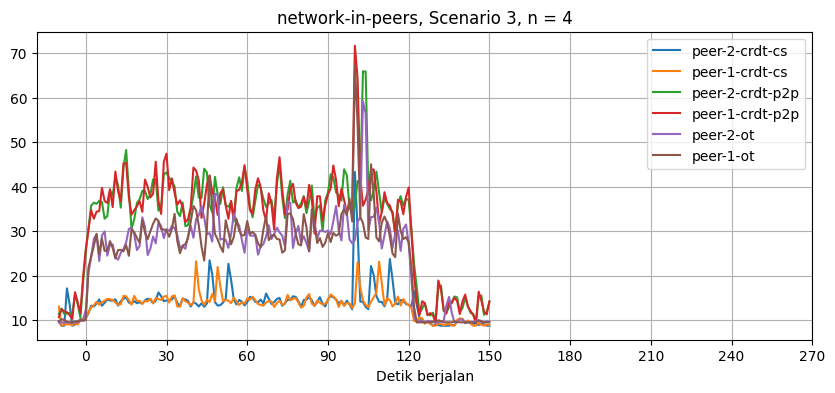

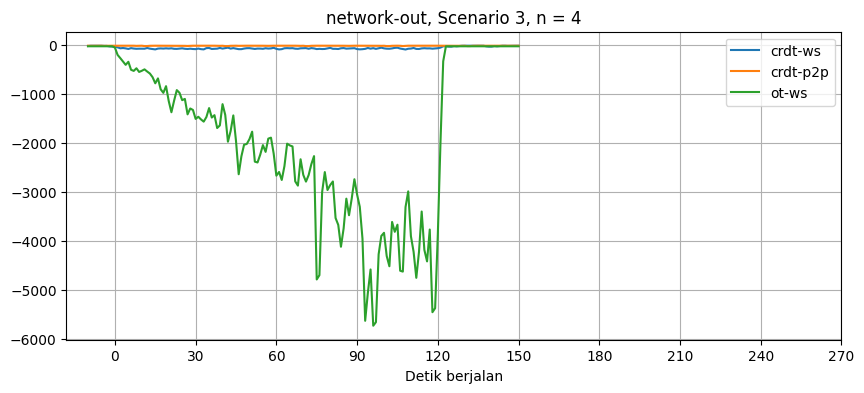

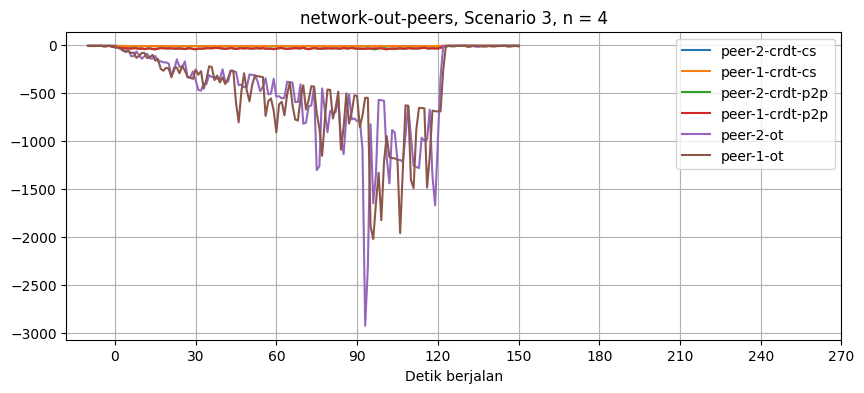

Currently computing for peers (8, 'n08')


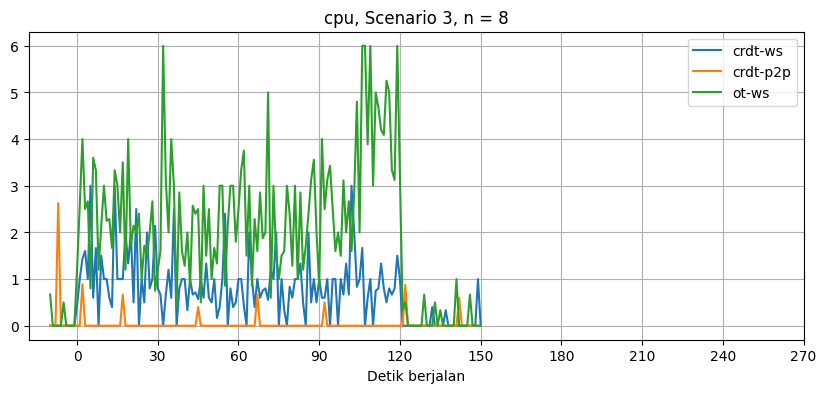

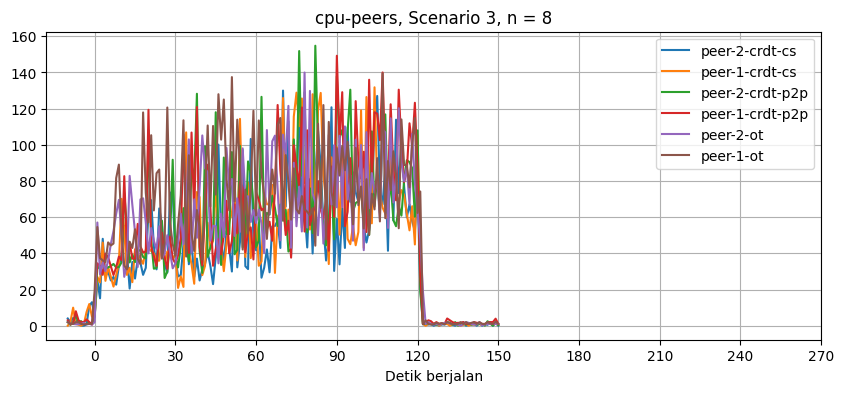

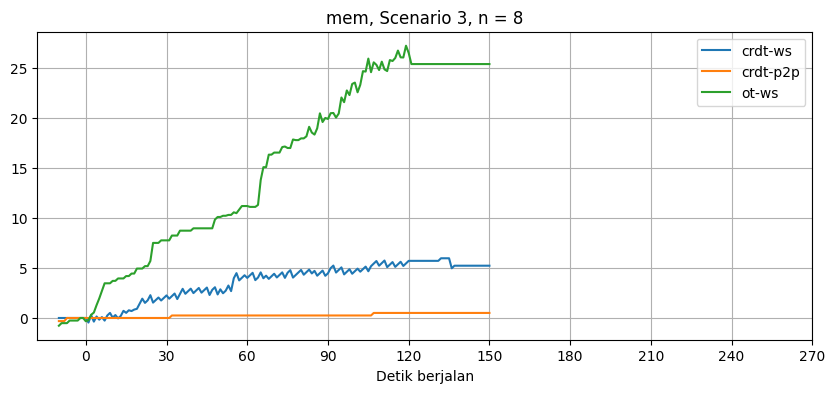

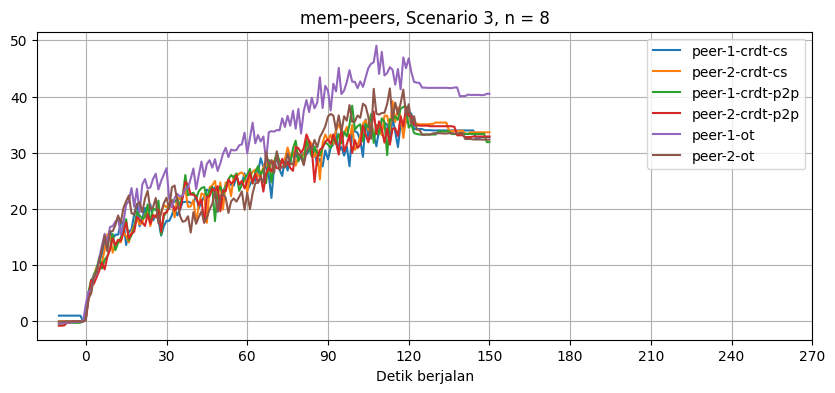

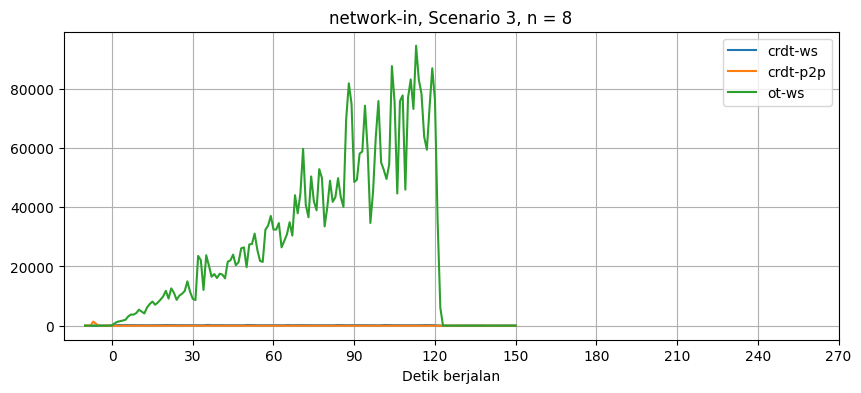

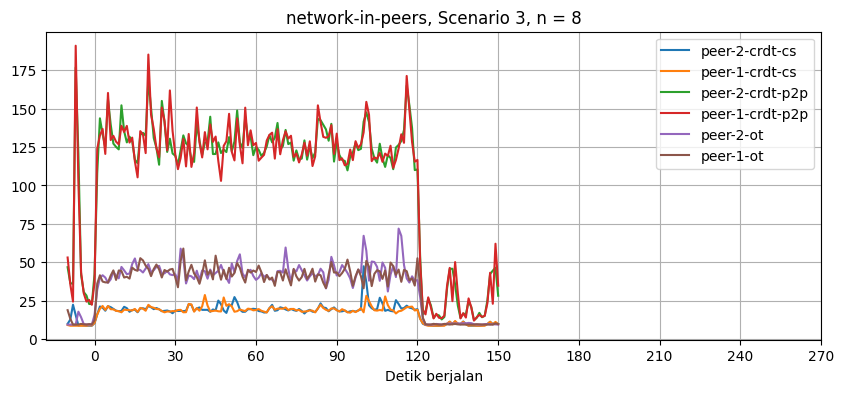

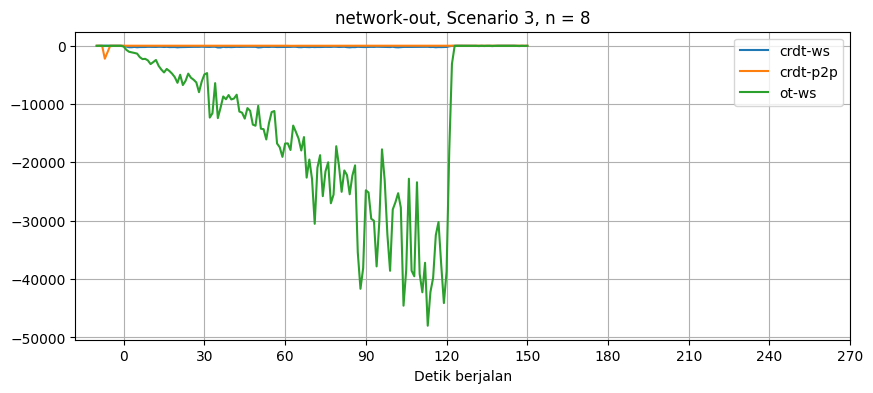

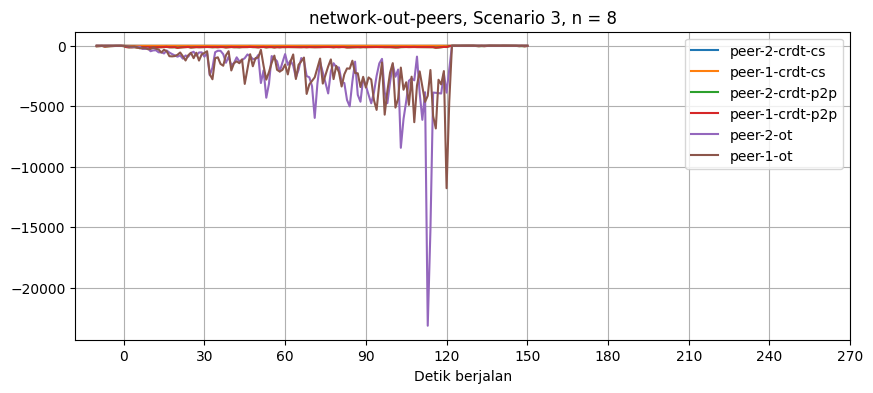

In [182]:
scenario(2)

Currently computing Scenario (4, 's4')
Currently computing for peers (2, 'n02')


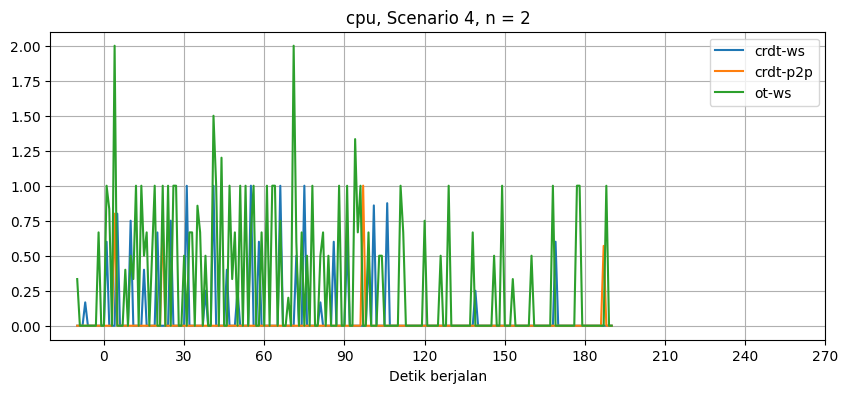

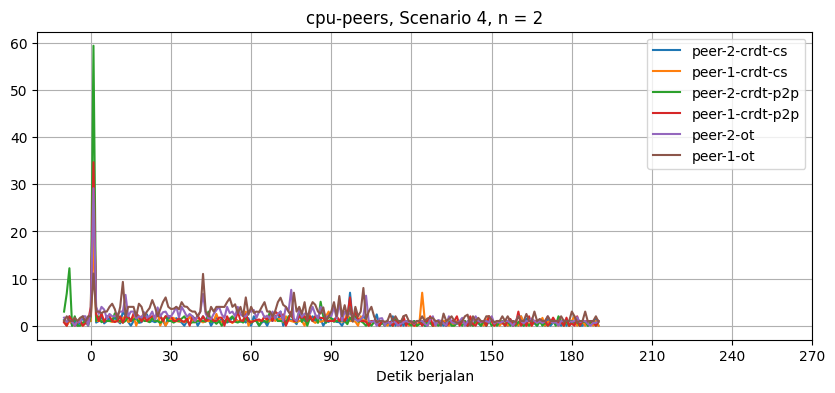

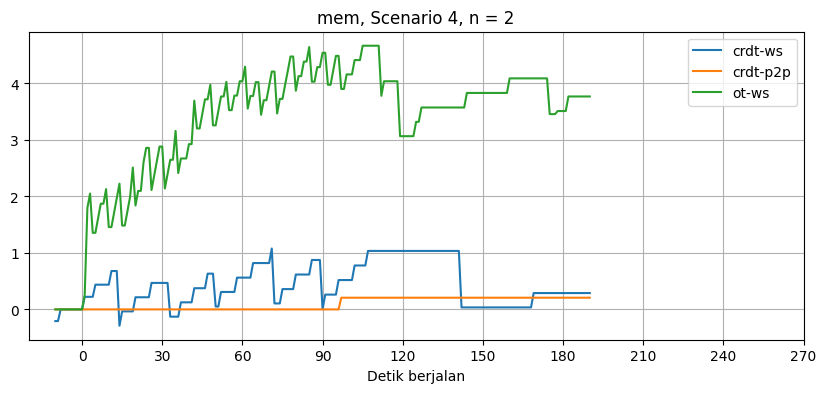

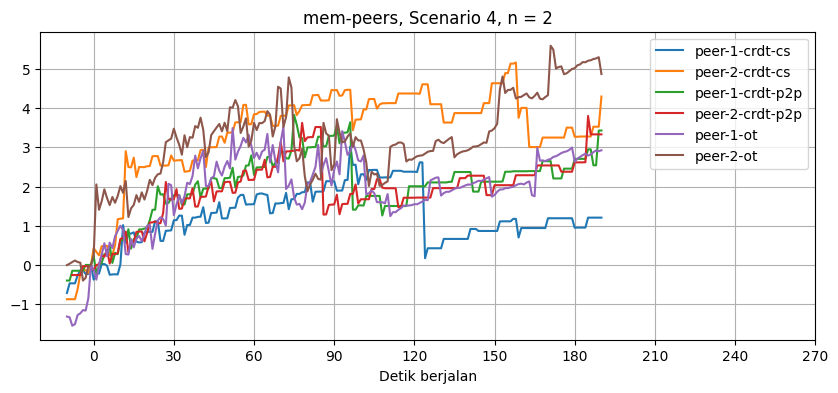

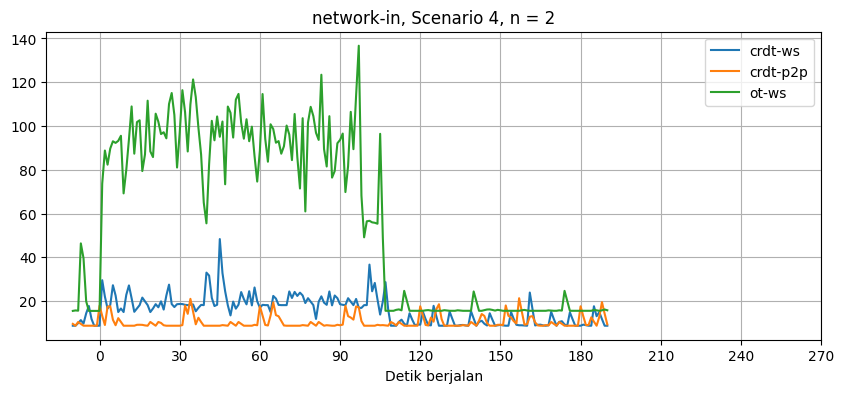

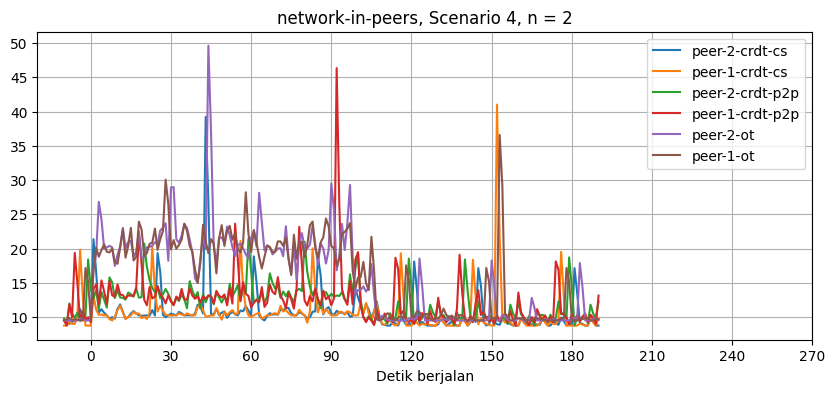

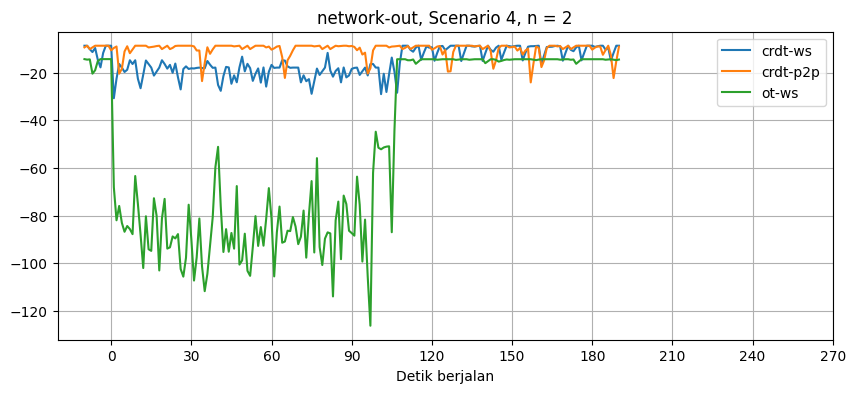

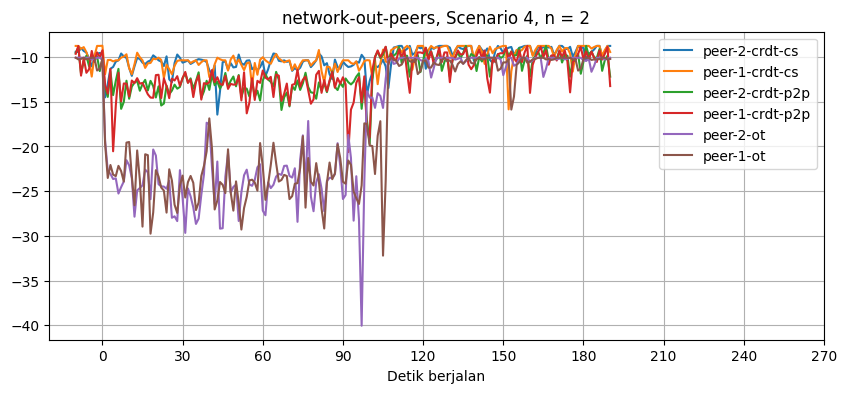

Currently computing for peers (4, 'n04')


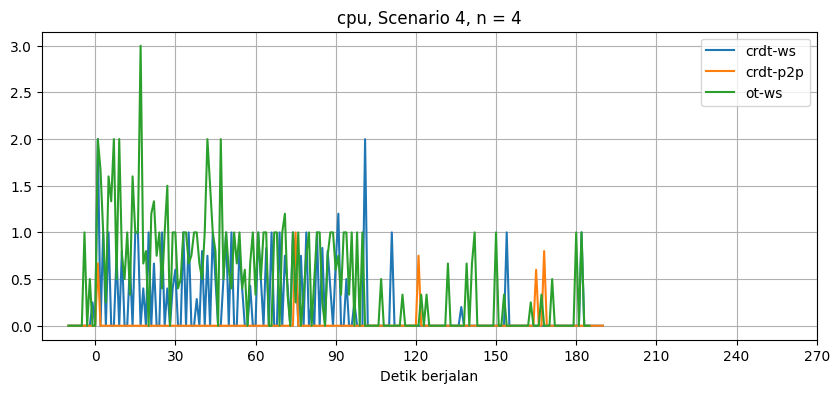

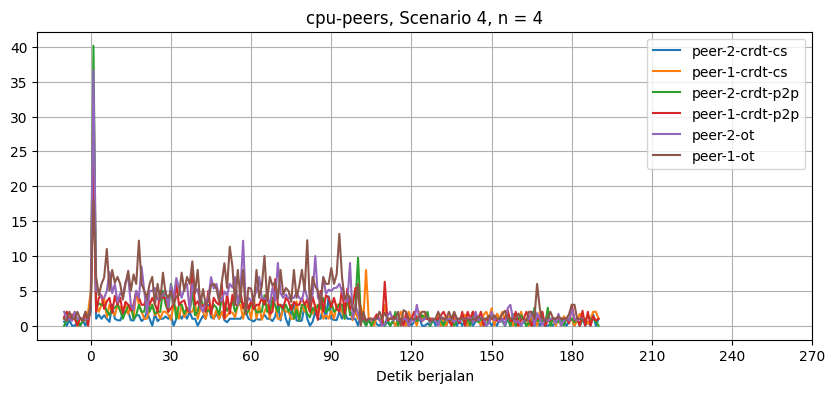

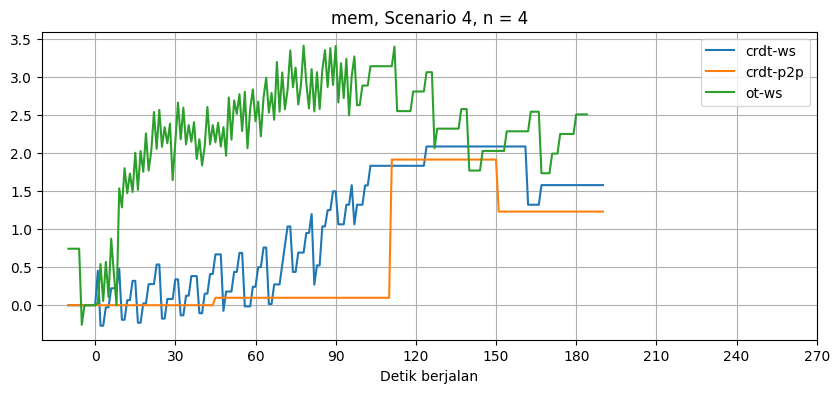

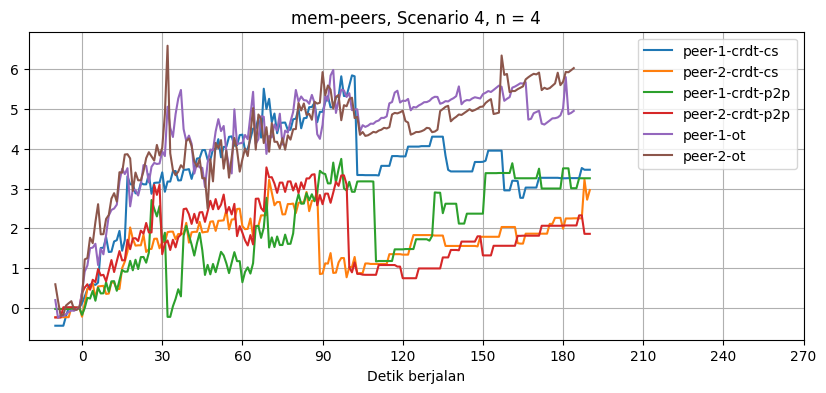

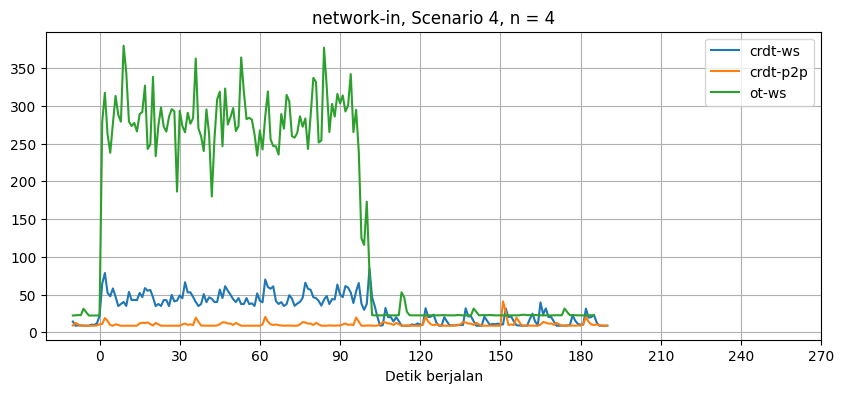

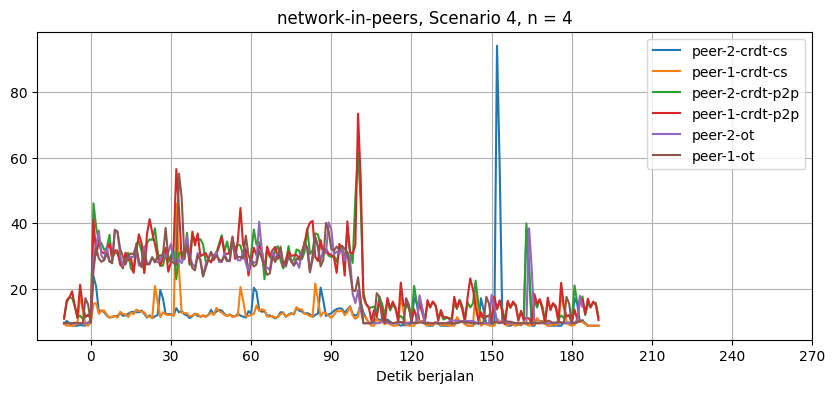

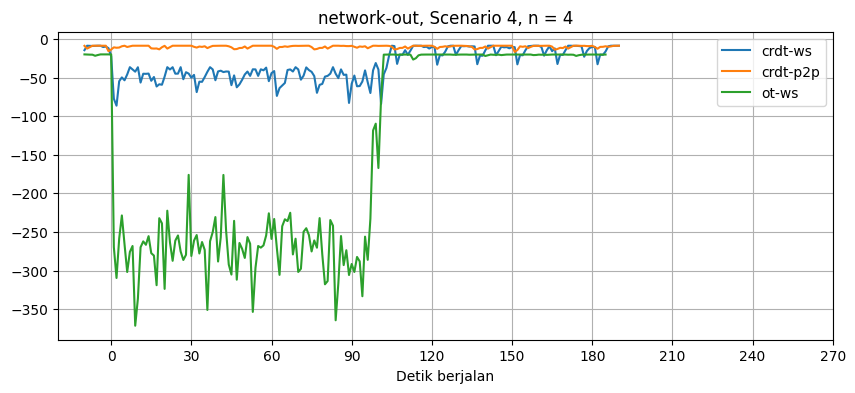

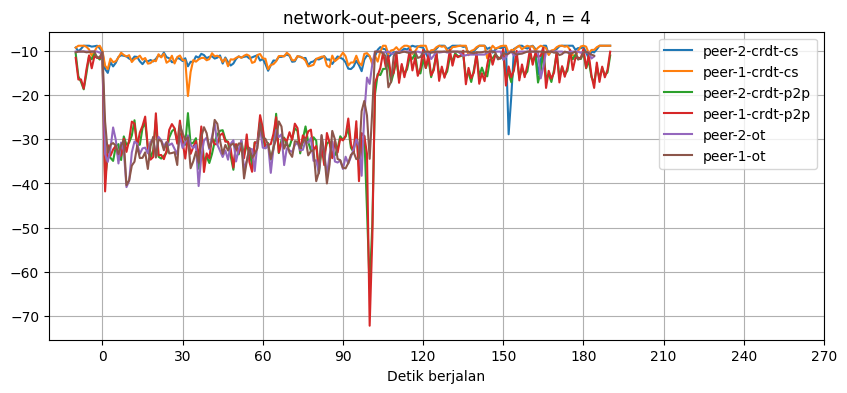

Currently computing for peers (8, 'n08')


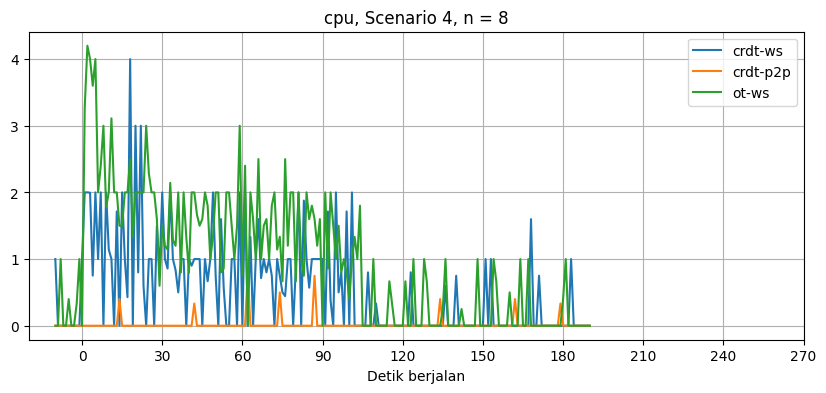

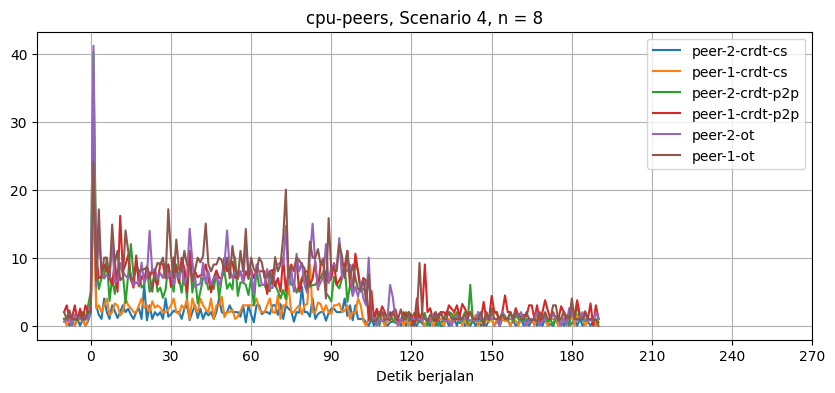

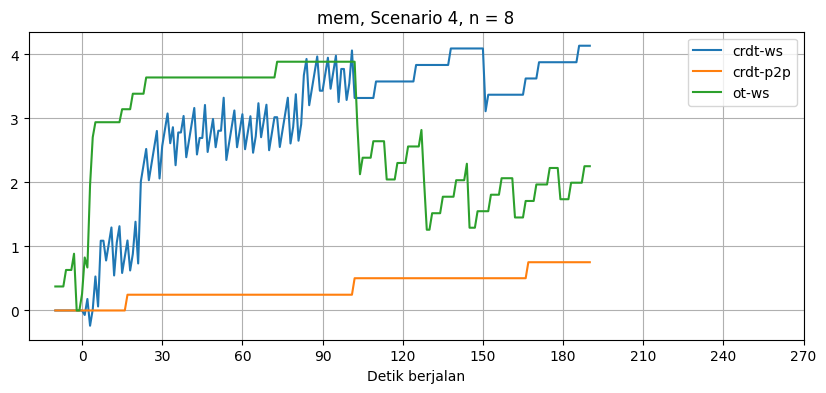

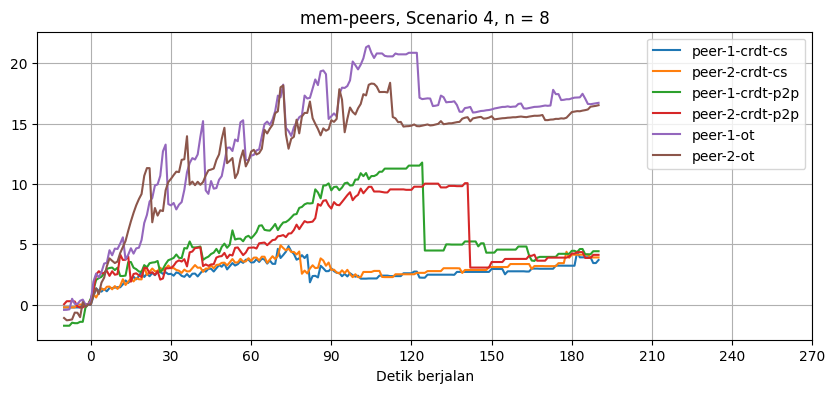

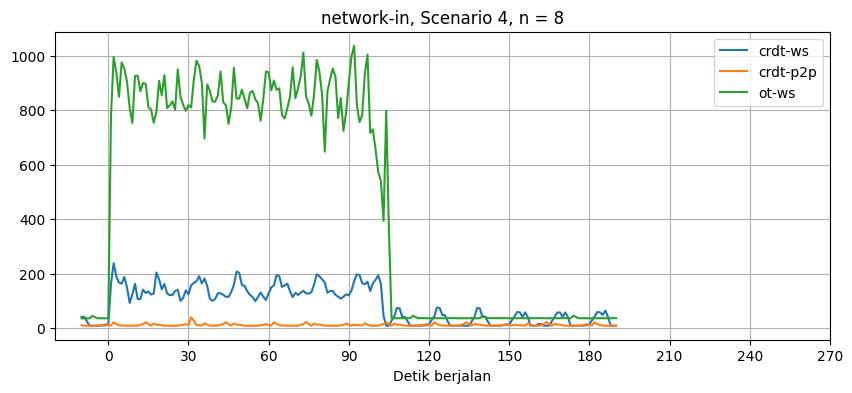

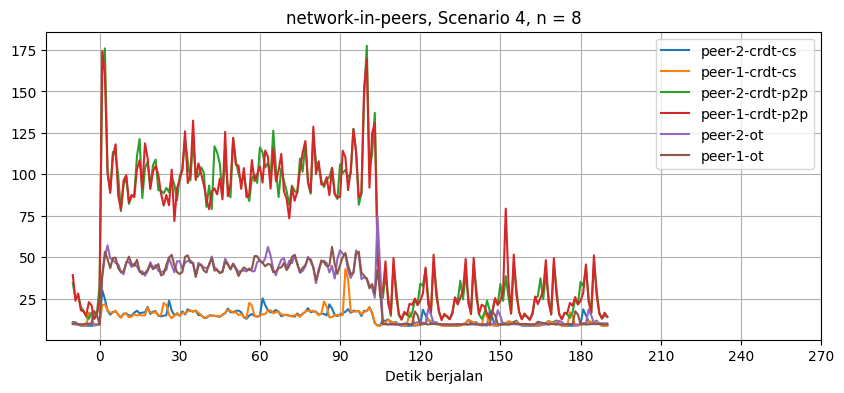

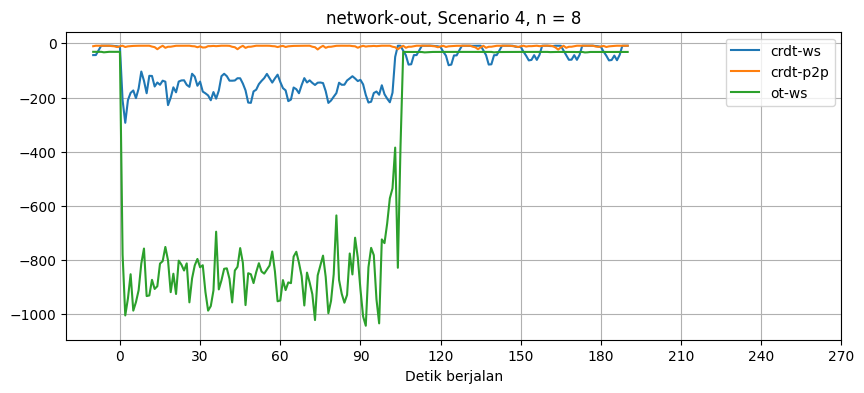

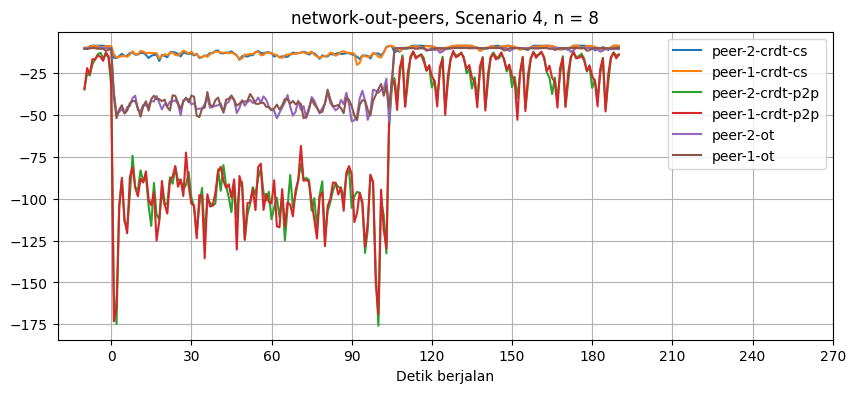

In [172]:
scenario(3)